<a href="https://colab.research.google.com/github/StephenMa1511/DeepLearning/blob/main/DL_GWP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DEEP LEARNING GROUP WORK PROJECT 3

|  |  |
|:---|:---|
|**Student name** |  |
| *Ma Quang Son*  |       |
|*Heathcliff Tatenda Nyambiya* | |
|*Joseph Olusegun Osuntoki* ||


## Introduction

In this third installment of our deep learning methods exploration, we venture yet again into the dynamic space, only this time we will immerse ourselves into the ever-exciting and contentious cryptocurrency market. We will uncover the issues underpinning the time series data itself and peer into the useful techniques to mitigate the challenges that consequently arise. Amidst the cryptocurrency landscape evolving rapidly, there's a surge in demand for sophisticated predictive models to navigate these dynamic markets effectively.

We will begin by retrieving 1825 observations that span 5 years of time series data for 3 cryptocurrency assets. Through performing analysis of the different signals we will uncover some insights from the statistical properties embedded in them. Utilizing advanced techniques, we will forecast the behaviour of Binance Coin (BNB) based on lagged versions of daily returns from Bitcoin and Ethereum. We aim to predict the sign of the 3-day ahead return of BNB, with a target label of 1 signifying a positive return and 0 indicating otherwise.

The approach this time will entail developing the deep learning models we have previously examined from the past research conducted. By now, we are familiar with Multilayer Perceptrons (MLP), Long Short-Term Memory (LSTM) networks, and Convolutional Neural Networks (CNN) based on Gramian Angular Field (GAF). Furthermore, we will train and test our three models using a single train/test split methodology to ensure a rigorous evaluation of their predictive performance.

On the other hand, we will introduce and extend our analysis to incorporate a walk-forward method to train the models. This will essentially assist us in dealing with the issue of data or information leakage between the training and test sets that can arise when working with serially correlated time series data. So, this should allow us to determine the robustness of our models while they are under varying conditions and assess their potential for real-world applications.

While the prior research determined to focus on stocks and ETFs, the overarching goal this time is to emphasise that these models can be applied to various financial instruments. This will highlight, once again, their efficient and versatile capabilities, now in forecasting cryptocurrency returns as well as their practical and general usage in the market for digital assets. By drawing actionable insights from our models and their results, we will communicate these in a non-technical manner. Lastly, we hope to contribute to the ongoing discourse surrounding deep learning applications in cryptocurrency markets.


## STEP 1

## Library Imports

In [ ]:
# @title
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping



## For Any Package Installations...

In [ ]:
from sklearn.preprocessing import StandardScaler
# model evaluation
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    cohen_kappa_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import keras


In [ ]:
#Function
def roc_auc_results(model, X_train, y_train,X_test,y_test ):
    y_predict_dl = model.predict(X_test)

    dl_probs_train = model.predict(X_train).flatten()
    dl_probs_test = model.predict(X_test).flatten()

    dl_fpr_train, dl_tpr_train, _ = roc_curve(y_train, dl_probs_train)
    dl_fpr_test, dl_tpr_test, _ = roc_curve(y_test, dl_probs_test)

    ROC_AUC_test = roc_auc_score(y_test, dl_probs_test)
    ROC_AUC_train = roc_auc_score(y_train, dl_probs_train)

    #no skill probs
    ns_probs = np.random.random(size = len(dl_probs_test))
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No skill")

    print('KerasClassifier train AUC score: ', roc_auc_score(y_train, dl_probs_train))
    print('KerasClassifier test AUC score: ', roc_auc_score(y_test, dl_probs_test))
    plt.plot(dl_fpr_train, dl_tpr_train, color = 'k', label="DL train AUC")
    plt.plot(dl_fpr_test, dl_tpr_test, color = "r", label="DL test AUC")
    plt.legend()
    plt.title('ROC_AUC Curve Comparison')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Retrieving the Financial Data From YFinance

In this GWP, we will be using the lag versions of daily returns of 3 crypto currencies which are Bitcoin, Ethereum and BNB as predictors to forecast the sign of 3 days ahead return of BNB. Our target will be 1 if the 3 day ahead return is predicted possitve, and 0 otherwise

Our orgininal data consist of 5 year of historical daily data which is roughly 1825 observations

In [ ]:
# List of stock tickers
cryptos = ['BTC-USD', 'ETH-USD', 'BNB-USD']

# Retrieve data from Yahoo Finance
data = yf.download(cryptos, start='2019-03-20', end='2024-03-20')['Adj Close']

# Create a DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df.head()


[*********************100%%**********************]  3 of 3 completed


Ticker,BNB-USD,BTC-USD,ETH-USD
Date,,,
2019-03-20,15.280023,4087.476318,140.686356
2019-03-21,14.517393,4029.326904,136.636063
2019-03-22,15.266424,4023.968262,137.181442
2019-03-23,15.235995,4035.826416,138.239868
2019-03-24,17.285357,4022.168213,136.986923


## Time Series Plot of 3 Cryptocurrencies

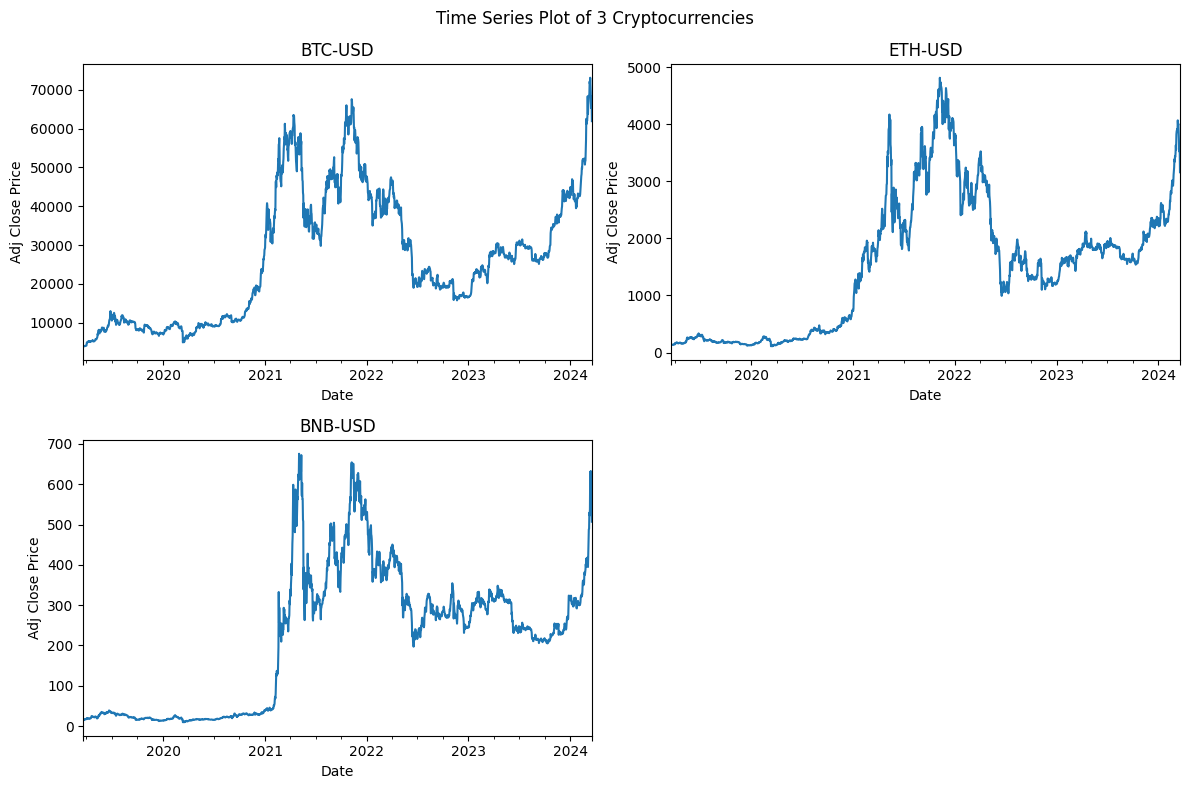

In [ ]:
# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(cryptos):
        crypto = cryptos[i]
        df[crypto].plot(ax=ax, title=crypto)
        ax.set_ylabel('Adj Close Price')
        ax.set_xlabel('Date')
    else:
        ax.axis('off')  # Turn off axes for empty subplots
plt.suptitle("Time Series Plot of 3 Cryptocurrencies")
plt.tight_layout()
plt.show()


## Daily Returns of the 3 Cryptocurrencies

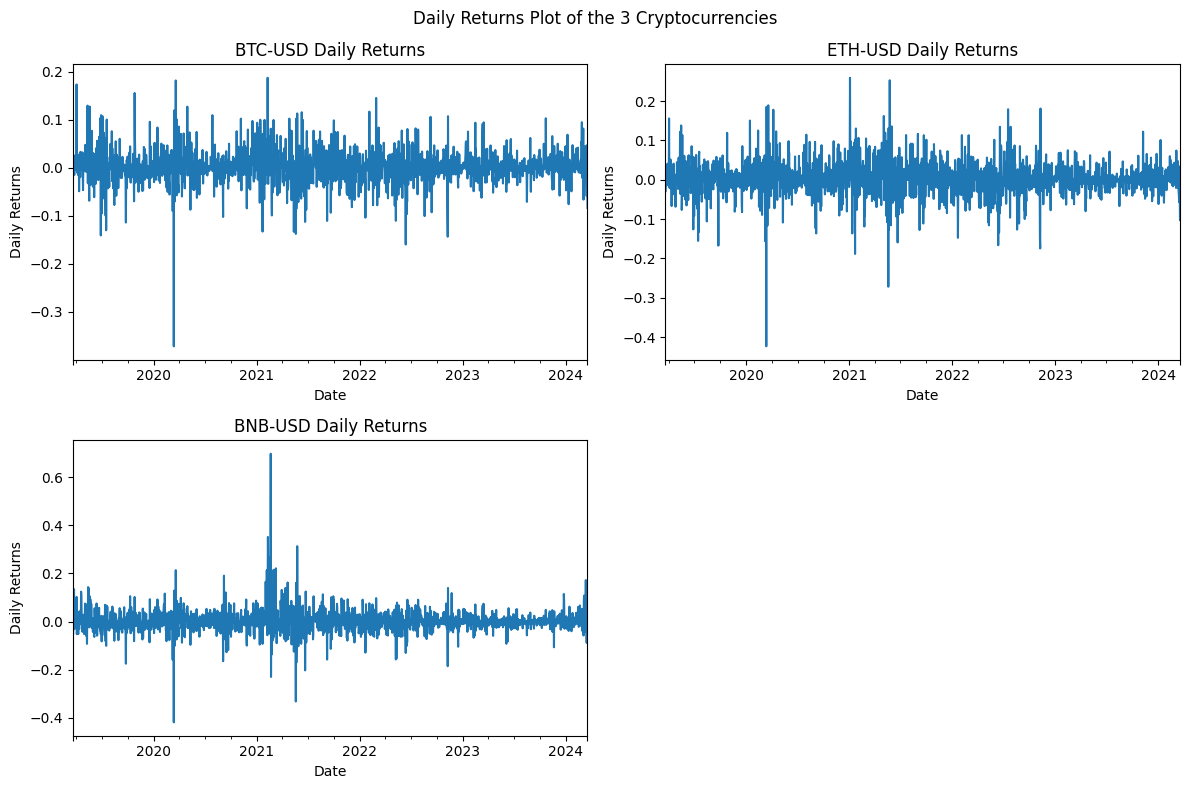

In [ ]:
# Calculate daily returns
returns = df.pct_change()

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(cryptos):
        crypto = cryptos[i]
        returns[crypto].plot(ax=ax, title=f'{crypto} Daily Returns')
        ax.set_ylabel('Daily Returns')
        ax.set_xlabel('Date')
    else:
        ax.axis('off')  # Turn off axes for empty subplots

plt.suptitle("Daily Returns Plot of the 3 Cryptocurrencies")
plt.tight_layout()
plt.show()


### Distribution Analysis of the 3 Cryptocurrency Daily Returns using Histograms

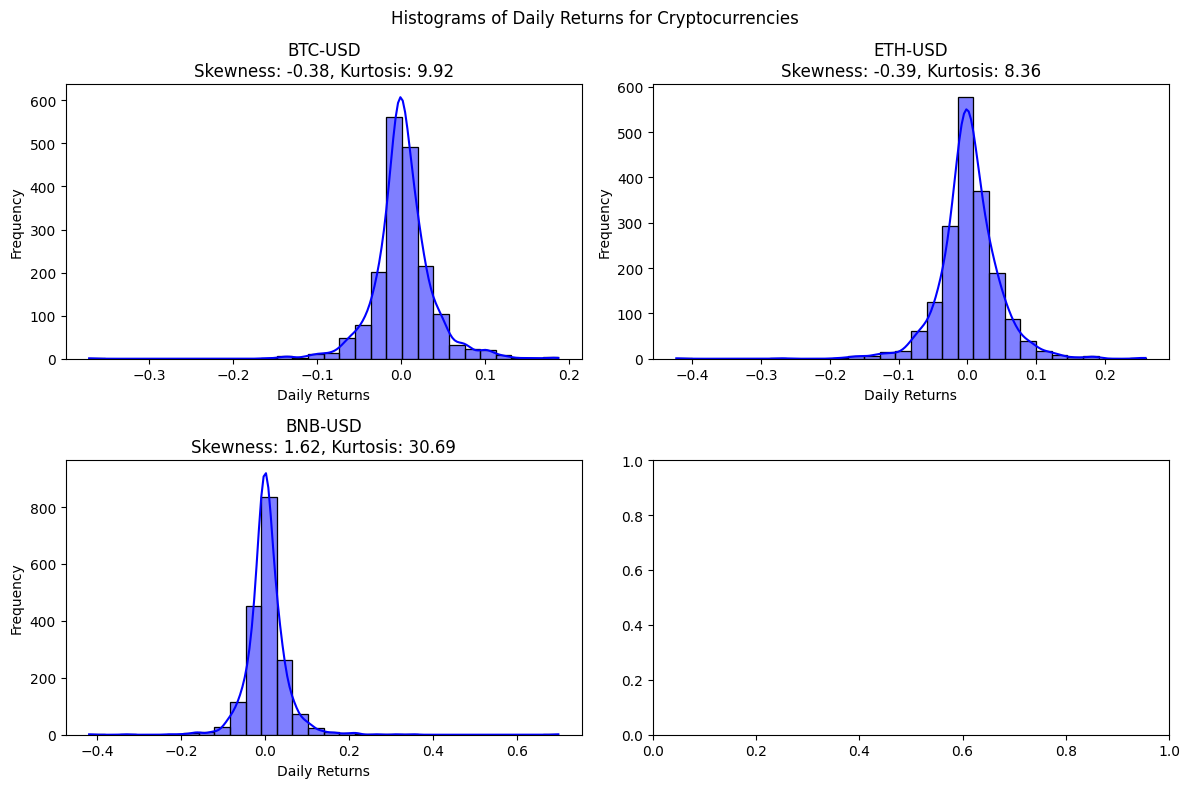

In [ ]:
import seaborn as sns

# Create a figure and axis objects for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
fig.suptitle('Histograms of Daily Returns for Cryptocurrencies')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for daily returns of each cryptocurrency
for i, (crypto, ax) in enumerate(zip(cryptos, axes)):
    sns.histplot(returns[crypto], bins=30, kde=True, ax=ax, color='blue')
    skewness = returns[crypto].skew()
    kurtosis = returns[crypto].kurtosis()
    ax.set_title(f'{crypto}\nSkewness: {skewness:.2f}, Kurtosis: {kurtosis:.2f}')
    ax.set_xlabel('Daily Returns')
    ax.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()


### Joint Distribution Plots of Daily Returns for Cryptocurrencies

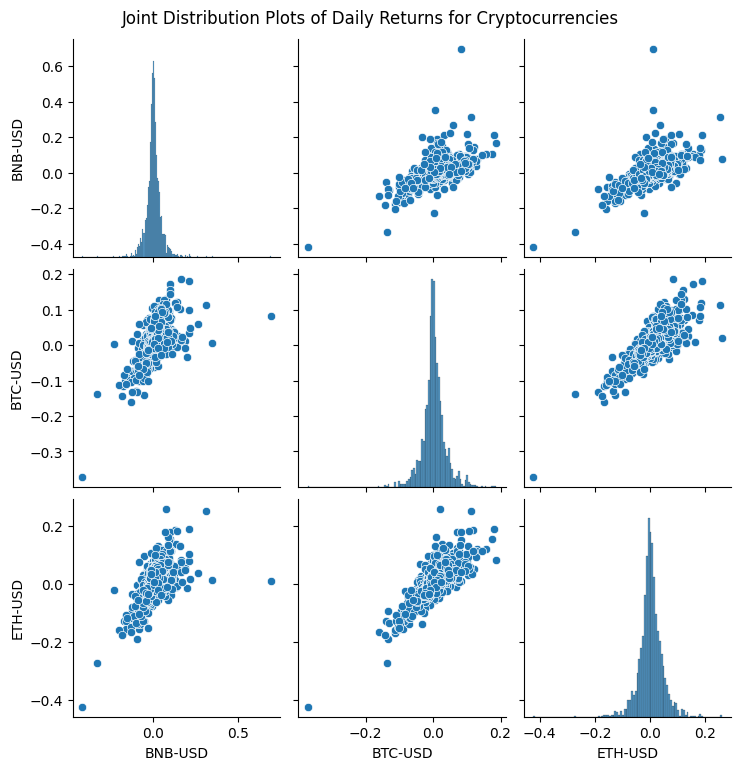

In [ ]:
# Joint Distribution Plot
sns.pairplot(returns, kind='scatter')
plt.suptitle('Joint Distribution Plots of Daily Returns for Cryptocurrencies', y=1.02)
plt.show()


### Correlation Heatmap of Daily Returns for Cryptocurrencies

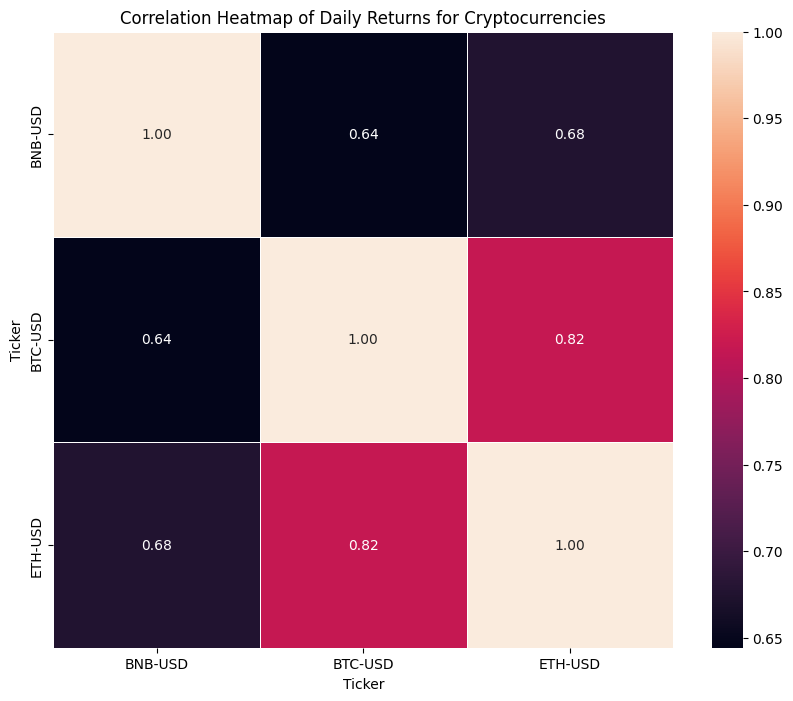

In [ ]:
# Calculate the correlation matrix
correlation_matrix = returns.corr()

# Create a heatmap of the correlation matrix with a dark to light color palette
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Daily Returns for Cryptocurrencies')
plt.show()


### ADF Test Results for Daily Returns of Cryptocurrencies For Stationarity

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Perform the ADF test for each cryptocurrency
adf_results = {}
for col in returns.columns:
    result = adfuller(returns[col].dropna())
    adf_results[col] = {'ADF Statistic': result[0], 'p-value': result[1], 'Critical Values': result[4]}

# Print the ADF test results
print("ADF Test Results for Daily Returns of Cryptocurrencies:")
for crypto, result in adf_results.items():
    print(f"{crypto}: ADF Statistic = {result['ADF Statistic']}, p-value = {result['p-value']}")
    print(f"Critical Values: {result['Critical Values']}")
    print("Time Series is Stationary" if result['p-value'] < 0.05 else "Time Series is Non-stationary")
    print()


ADF Test Results for Daily Returns of Cryptocurrencies:
BNB-USD: ADF Statistic = -11.044634982054198, p-value = 5.2606055387886657e-20
Critical Values: {'1%': -3.4339560393603112, '5%': -2.8631328654399884, '10%': -2.5676179883293875}
Time Series is Stationary

BTC-USD: ADF Statistic = -20.14201566265754, p-value = 0.0
Critical Values: {'1%': -3.4339441475744668, '5%': -2.8631276157416945, '10%': -2.5676151930364455}
Time Series is Stationary

ETH-USD: ADF Statistic = -12.818556458672568, p-value = 6.224018667513861e-24
Critical Values: {'1%': -3.4339560393603112, '5%': -2.8631328654399884, '10%': -2.5676179883293875}
Time Series is Stationary



### ACF Plots of The Cryptocurrency Daily Returns

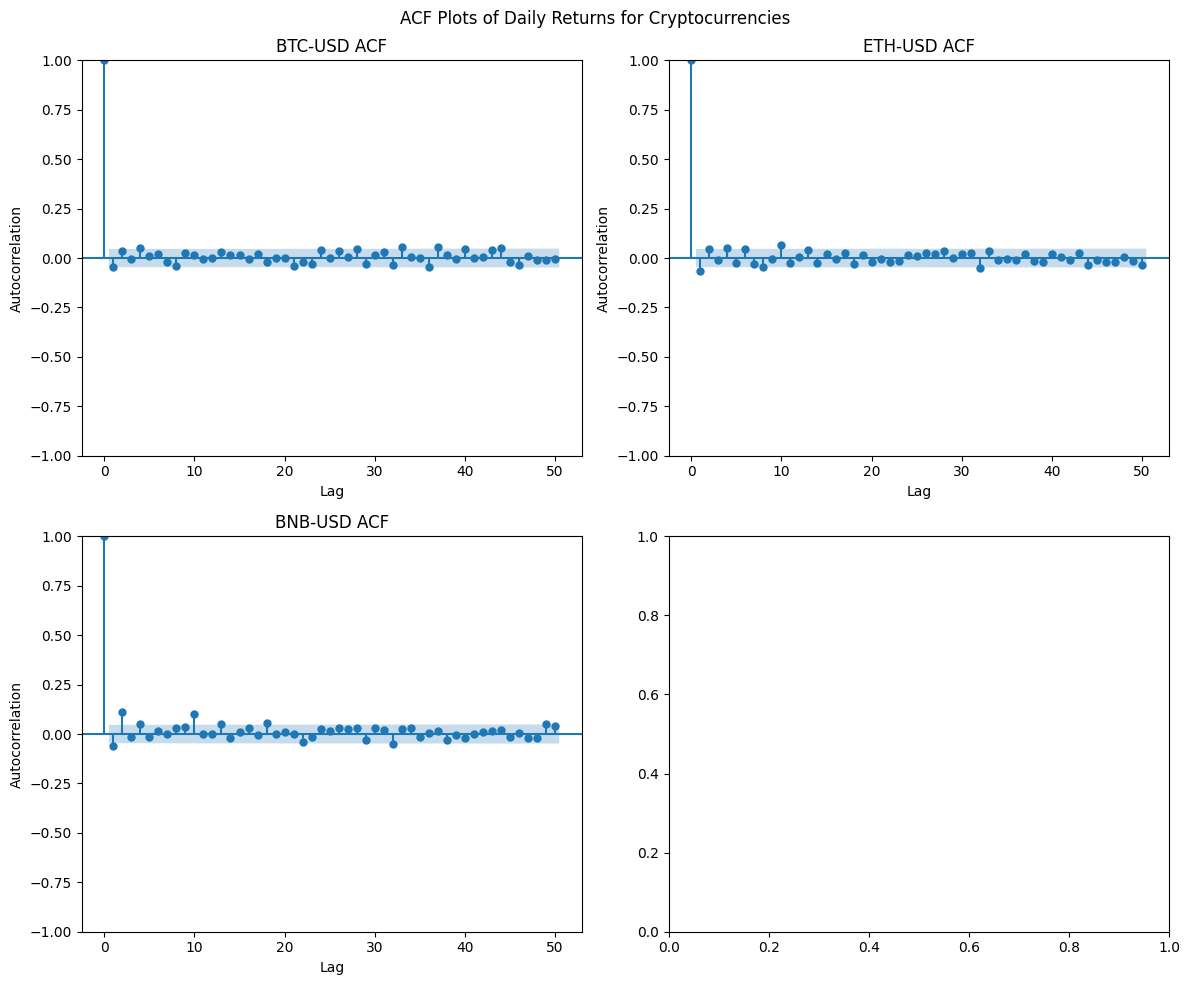

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Create a figure and axis objects for the subplots of ACF plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('ACF Plots of Daily Returns for Cryptocurrencies')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot ACF plots for daily returns of each cryptocurrency
for i, (crypto, ax) in enumerate(zip(cryptos, axes)):
    plot_acf(returns[crypto].dropna(), ax=ax, lags=50, title=f'{crypto} ACF')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')

# Adjust layout
plt.tight_layout()
plt.show()


### PACF Plots of The Cryptocurrency Daily Returns

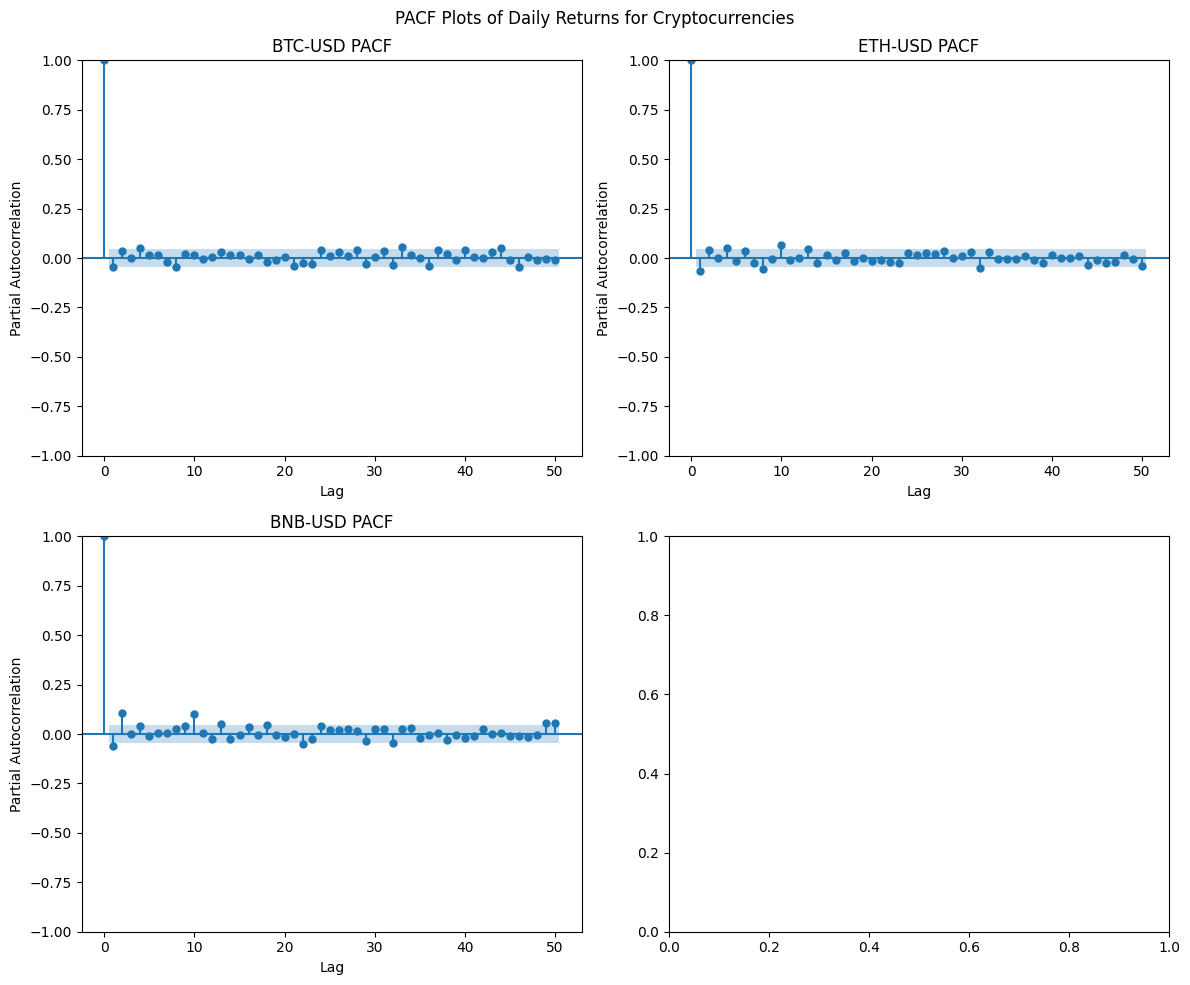

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Create a figure and axis objects for the subplots of PACF plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('PACF Plots of Daily Returns for Cryptocurrencies')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot PACF plots for daily returns of each cryptocurrency
for i, (crypto, ax) in enumerate(zip(cryptos, axes)):
    plot_pacf(returns[crypto].dropna(), ax=ax, lags=50, title=f'{crypto} PACF')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Partial Autocorrelation')

# Adjust layout
plt.tight_layout()
plt.show()


### Volatility Analysis of the Cryptocurrency Daily Returns

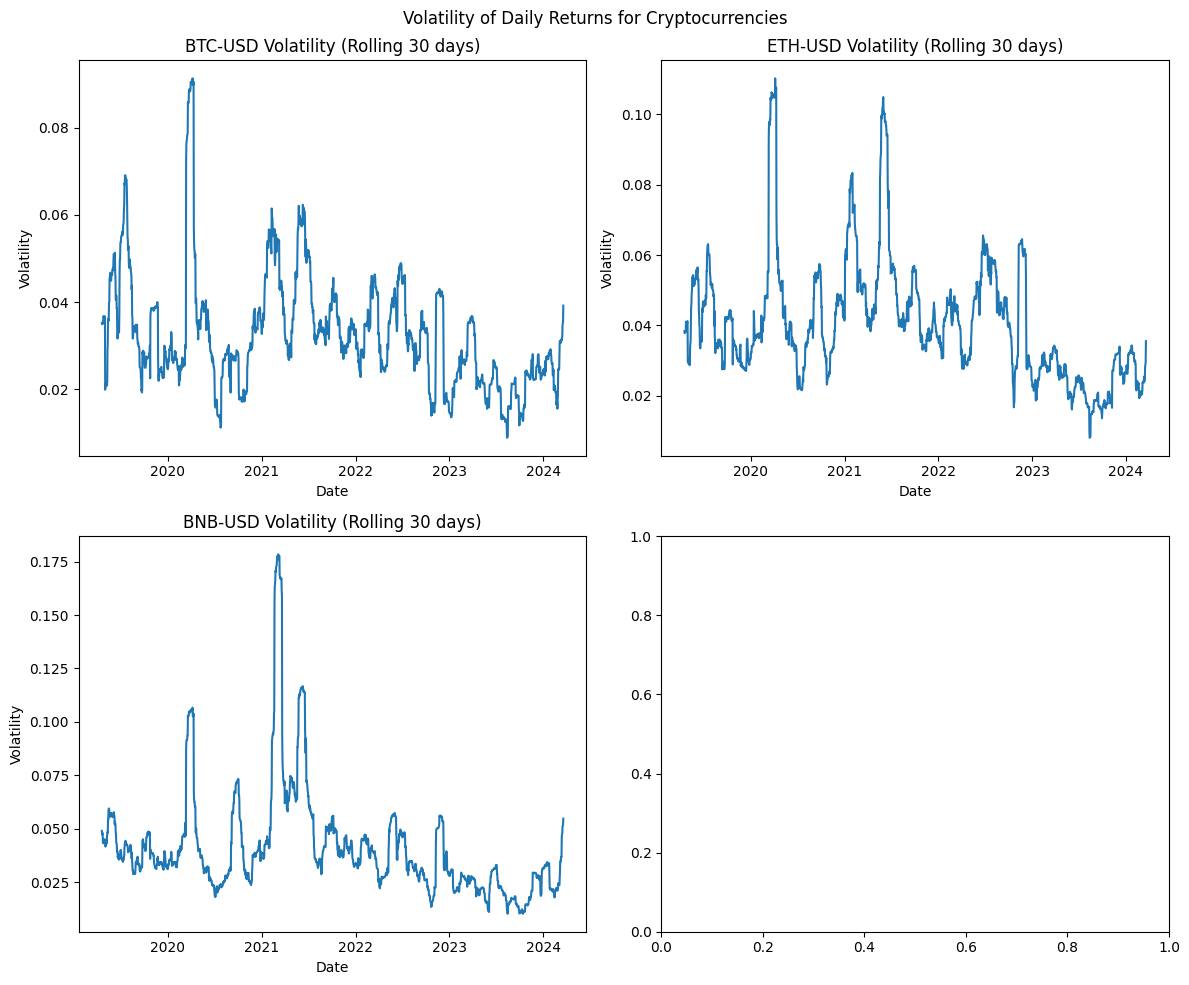

In [ ]:
# Define the window size for the rolling standard deviation (volatility)
window_size = 30  # You can adjust this value as needed

# Calculate the rolling standard deviation (volatility) for each cryptocurrency's daily returns
rolling_volatility = returns.rolling(window=window_size).std()

# Create a figure and axis objects for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle('Volatility of Daily Returns for Cryptocurrencies')

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot volatility of daily returns for each cryptocurrency
for i, (crypto, ax) in enumerate(zip(cryptos, axes)):
    ax.plot(rolling_volatility.index, rolling_volatility[crypto])
    ax.set_title(f'{crypto} Volatility (Rolling {window_size} days)')
    ax.set_xlabel('Date')
    ax.set_ylabel('Volatility')

# Adjust layout
plt.tight_layout()
plt.show()


## STEP 1 - Building MLP, LSTM, CNN based on GAF models using single train/test split

### MLP Model

In [ ]:
#preprocessing
data = df.copy()

tickers = ['BNB','BTC','ETH']
data.columns = tickers
lags = [1,5,10,20]
return_days_ahead = 3
for lag in lags:
    for ticker in tickers:
        data[f'{ticker}_ret{lag}'] = data[ticker]/data[ticker].shift(lag) - 1
data['output'] = data['BNB'].shift(-return_days_ahead)/data['BNB'] - 1
data['output'] = (data['output'] > 0).astype('float32')
data = data.dropna()
data = data.iloc[:,3:]
X, y = data.iloc[:,:-1].astype('float32'), data.iloc[:,-1]
# split train test
test_split = 0.2 # test split
test_size = int(test_split * len(df));  # Number of observations in the test sample
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

#Scale the dataset with standard scaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Here we built a basic MLP model with 4 hidden layers of size (64,32,16,8), and add dropout after each dense layer to introduce noise in the trainning

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

class weight:  {0: 1.2549237728118896, 1: 1.0}
Restoring model weights from the end of the best epoch: 70.
Epoch 90: early stopping
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0

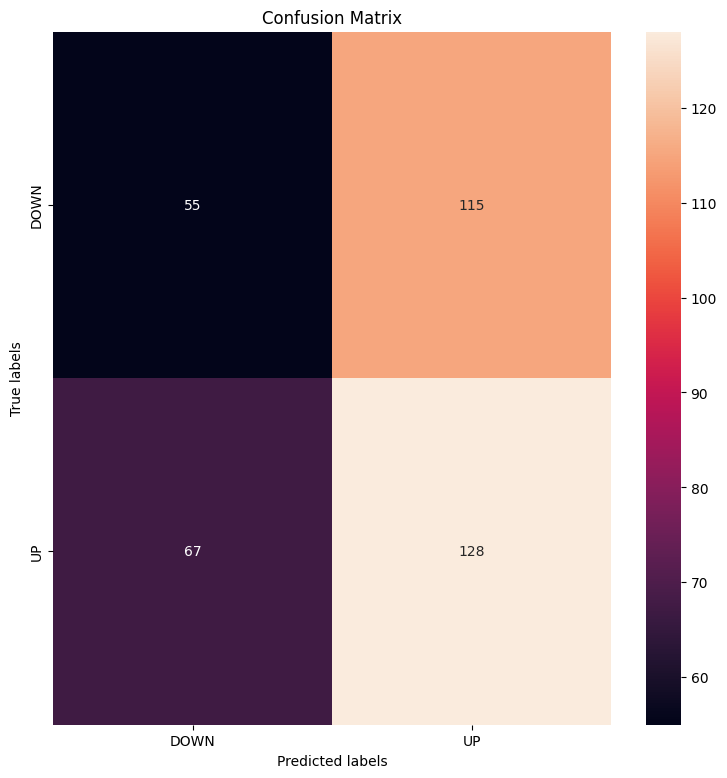

12/12 [==============================] - 0s 3ms/step
KerasClassifier train AUC score:  0.49070365029917956
KerasClassifier test AUC score:  0.5135746606334842


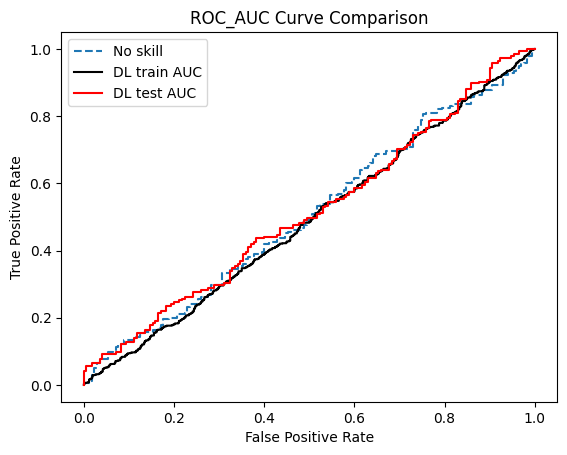

Long - Short strategy Return = -14.04761773846147 %
Long only strategy Return = 21.503369118079373 %
Buy and Hold Return = 52.31046286439707 %


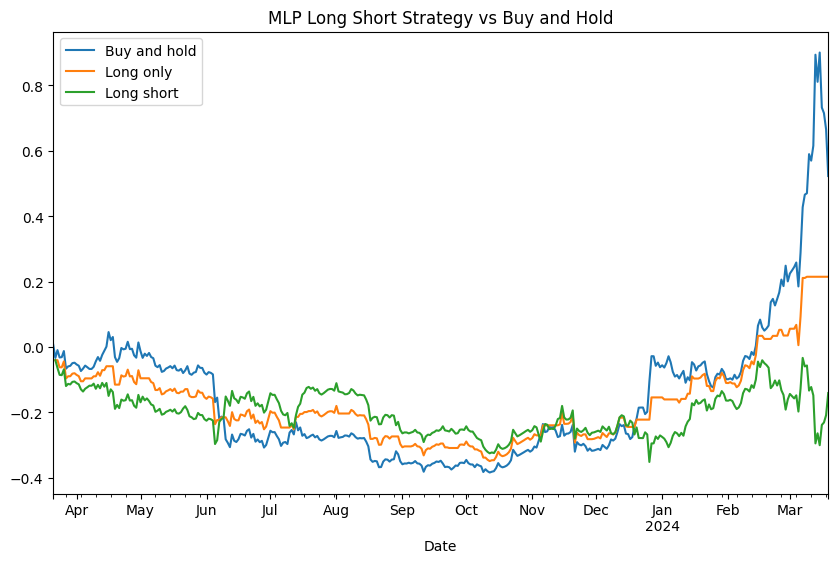

In [ ]:
tf.keras.backend.clear_session();  # We clear the backend to reset the random seed process
tf.random.set_seed(1234); # We will set a random seed so that results obtained are somewhat replicable

act_fun = "relu";
hp_units = 64;
hp_units_2 = 32;
hp_units_3 = 16;
hp_units_4 = 8;
n_dropout = 0.2;

model = tf.keras.models.Sequential();
model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun));
model.add(tf.keras.layers.Dropout(n_dropout));
model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun));
model.add(tf.keras.layers.Dropout(n_dropout));
model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun));
model.add(tf.keras.layers.Dropout(n_dropout));
model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun));
model.add(tf.keras.layers.Dropout(n_dropout));
model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"));

hp_lr = 1e-5  # Learning rate
adam = tf.keras.optimizers.Adam(learning_rate=hp_lr);  # Adam optimizer
model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"]);

es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",mode="max",verbose=1,
  patience=20,restore_best_weights=True);

class_weight = {0: (np.mean(y_train) / 0.5) * 1.2, 1: 1.0};
print('class weight: ', class_weight);

history = model.fit(X_train_scaled,y_train,validation_split=0.2,epochs=500,batch_size=32,verbose=0,
                    callbacks=[es],class_weight=class_weight);

model.summary();

## To test model performance
y_prob = model.predict(X_test_scaled).flatten();
y_pred = np.where(y_prob > 0.50, 1, 0).flatten();

acc = accuracy_score(y_test,y_pred);
print("Model accuracy in test: ", acc);

cm = metrics.confusion_matrix(y_test, y_pred);
plt.figure(figsize=(9, 9));
ax = plt.subplot();
sns.heatmap(cm, annot=True, fmt="g", ax=ax);
# annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["DOWN", "UP"]);
ax.yaxis.set_ticklabels(["DOWN", "UP"]);
plt.show()

#Roc_auc curve
roc_auc_results(model, X_train_scaled, y_train,X_test_scaled,y_test )

# Backtesting trading strategy
test_time = y_test.index
df_predictions = pd.DataFrame(
    {"Date": y_test.index, "Pred MLP": y_pred, "True values": y_test.values})

df_predictions['ret'] = data['BNB_ret1'].loc[test_time].values

df_predictions["Positions"] = np.where(df_predictions["Pred MLP"] > 0, 1,-1)

df_predictions["Strat_ret"] = (df_predictions["Positions"].shift(1) * df_predictions["ret"])

df_predictions["Strat_ret_L"] = (df_predictions["Pred MLP"].shift(1) * df_predictions["ret"])

df_predictions["Strat_CumRet"] = (df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["Strat_CumRet_L"] = (df_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["BH_CumRet"] = (df_predictions["ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))


Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Long_only_return = np.prod(1 + df_predictions["Strat_ret_L"]) - 1
Buy_Return = np.prod(1 + df_predictions["ret"]) - 1

print("Long - Short strategy Return =", Final_Return * 100, "%")
print("Long only strategy Return =", Long_only_return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
plt.figure(figsize = (10,6))
ax = plt.gca()
df_predictions.plot(x="Date", y="BH_CumRet", label = "Buy and hold", ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet_L", label = 'Long only', ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet", label = 'Long short', ax=ax)
plt.title(f'MLP Long Short Strategy vs Buy and Hold')
plt.show()

We can see from the resulting ROC AUC graph that our classifier did not do better than a random guessing with the ROC_AUC score of both train and test set are around 0.5

After training and evaluating model on the test set, we're going to creating a strategy that goes long if the prediction is positive and we will go short otherwise. Finally we will compare it with a buy and hold strategy.

We can see that our strategies perform poorly compared to a buy and hold strategy, its no surprise since the model's auc score on test set is just around 50%. And one more thing to take note is that our single MLP model is highly unstable since it produced different probability predictions every time we refit the model even though we have kept the same seed(1234). Thus the need for ensemble methods is highly required to maintain reproducible results.

### LSTM Model


In [ ]:
window_size = 30

X_train_lstm = []
y_train_lstm = []

for i in range(window_size, X_train_scaled.shape[0]):
    X_train_lstm.append(X_train_scaled[i - window_size : i, :])
    y_train_lstm.append(y_train.iloc[i])
X_train_lstm, y_train_lstm = np.array(X_train_lstm), np.array(y_train_lstm)

X_test_lstm = []
y_test_lstm = []

for i in range(window_size, X_test_scaled.shape[0]):
    X_test_lstm.append(X_test_scaled[i - window_size : i, :])
    y_test_lstm.append(y_test.iloc[i])
test_time = y_test.index[window_size:]
X_test_lstm, y_test_lstm = np.array(X_test_lstm), np.array(y_test_lstm)
print(X_train_lstm.shape, y_train_lstm.shape,X_test_lstm.shape, y_test_lstm.shape)


(1412, 30, 12) (1412,) (335, 30, 12) (335,)


We'll build a basic LSTM model with 4 LSTM layers each of 50 units followed by 3 dense layers with shape (20,10,1). We use dropout after each of the layers to introduce randomness to the training process to tackle the overfitting problem.

Epoch 1/100
18/18 [==============================] - 14s 210ms/step - loss: 0.6940 - val_loss: 0.6930
Epoch 2/100
18/18 [==============================] - 3s 147ms/step - loss: 0.6933 - val_loss: 0.6930
Epoch 3/100
18/18 [==============================] - 2s 95ms/step - loss: 0.6929 - val_loss: 0.6929
Epoch 4/100
18/18 [==============================] - 2s 90ms/step - loss: 0.6925 - val_loss: 0.6929
Epoch 5/100
18/18 [==============================] - 2s 89ms/step - loss: 0.6921 - val_loss: 0.6927
Epoch 6/100
18/18 [==============================] - 2s 90ms/step - loss: 0.6919 - val_loss: 0.6928
Epoch 7/100
18/18 [==============================] - 2s 89ms/step - loss: 0.6916 - val_loss: 0.6928
Epoch 8/100
18/18 [==============================] - 2s 91ms/step - loss: 0.6914 - val_loss: 0.6927
Epoch 9/100
18/18 [==============================] - 2s 131ms/step - loss: 0.6918 - val_loss: 0.6927
Epoch 10/100
18/18 [==============================] - 2s 107ms/step - loss: 0.6898 - val_loss: 0

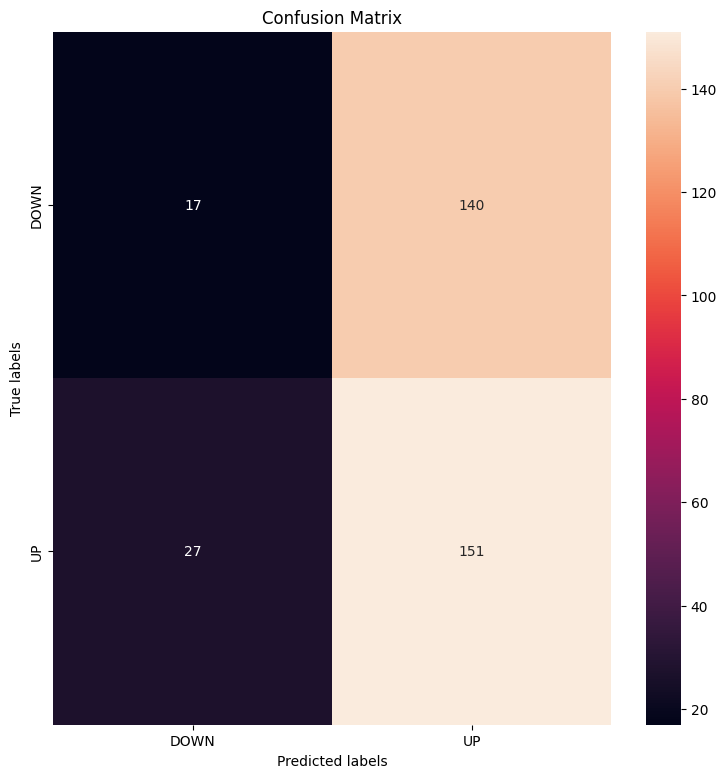

11/11 [==============================] - 0s 20ms/step
KerasClassifier train AUC score:  0.6305944337194337
KerasClassifier test AUC score:  0.4977456523294926


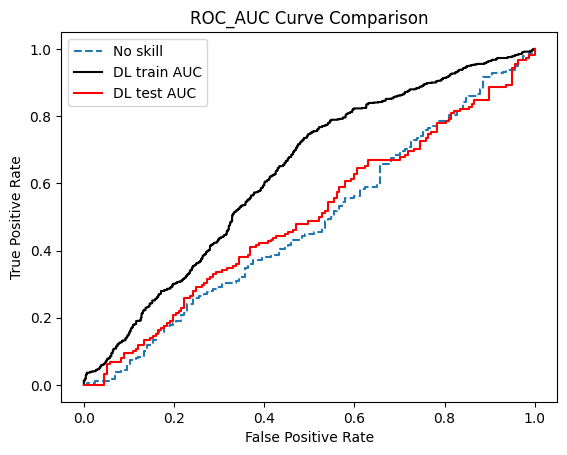

Long - Short strategy Return = 44.56785505466077 %
Long only strategy Return = 52.58197773741722 %
Buy and Hold Return = 57.13193461995307 %


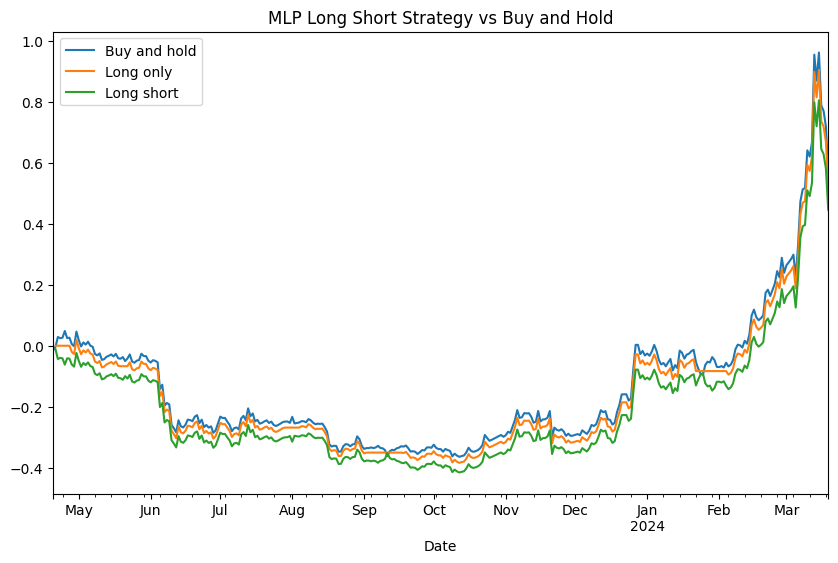

In [ ]:
#--------Building LSTM model-------------------
lstm_layers = 4
dense_structure = [20,10,1]
units_lstm = 50
n_dropout = 0.3
dense_act_fun = "relu"
final_act_fun = 'sigmoid'
hp_lr = 1e-4
loss = "binary_crossentropy"
epochs = 100
verbose = 1
batch_size = 64
SEED = 1234

tf.keras.backend.clear_session()
model = Sequential()

model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]),
    )
)
for layers in range(1,lstm_layers):
    if layers + 1 != lstm_layers:
        model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
        model.add(Dropout(n_dropout, seed=SEED))
    else:
        model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
        model.add(Dropout(n_dropout, seed=SEED))

for i, dense in list(enumerate(dense_structure)):
    if i + 1 < len(dense_structure):
        model.add(Dense(units=dense, activation=dense_act_fun))
        model.add(Dropout(n_dropout, seed=SEED))
    else:
        model.add(Dense(1,activation = final_act_fun))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

#return summary
#summary =  model.summary()

# fit the models
model.fit(
    X_train_lstm,
    y_train_lstm,
    validation_split=0.2,
    epochs= epochs,
    batch_size = batch_size,
    verbose = verbose,
    callbacks=[es],
)

model.summary();

#=============================================================

## To test model performance
y_prob_lstm = model.predict(X_test_lstm).flatten();
y_pred_lstm= np.where(y_prob_lstm > 0.50, 1, 0).flatten();

acc = accuracy_score(y_test_lstm,y_pred_lstm);
print("Model LSTM accuracy in test: ", acc);

cm = metrics.confusion_matrix(y_test_lstm, y_pred_lstm);
plt.figure(figsize=(9, 9));
ax = plt.subplot();
sns.heatmap(cm, annot=True, fmt="g", ax=ax);
# annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel("Predicted labels");
ax.set_ylabel("True labels");
ax.set_title("Confusion Matrix");
ax.xaxis.set_ticklabels(["DOWN", "UP"]);
ax.yaxis.set_ticklabels(["DOWN", "UP"]);
plt.show()

#Roc_auc curve
roc_auc_results(model, X_train_lstm, y_train_lstm,X_test_lstm,y_test_lstm )

# Backtesting trading strategy

df_predictions = pd.DataFrame(
    {"Date": test_time, "Pred MLP": y_pred_lstm, "True values": y_test_lstm})

df_predictions['ret'] = data['BNB_ret1'].loc[test_time].values

df_predictions["Positions"] = np.where(df_predictions["Pred MLP"] > 0, 1,-1)

df_predictions["Strat_ret"] = (df_predictions["Positions"].shift(1) * df_predictions["ret"])

df_predictions["Strat_ret_L"] = (df_predictions["Pred MLP"].shift(1) * df_predictions["ret"])

df_predictions["Strat_CumRet"] = (df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["Strat_CumRet_L"] = (df_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["BH_CumRet"] = (df_predictions["ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))


Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Long_only_return = np.prod(1 + df_predictions["Strat_ret_L"]) - 1
Buy_Return = np.prod(1 + df_predictions["ret"]) - 1

print("Long - Short strategy Return =", Final_Return * 100, "%")
print("Long only strategy Return =", Long_only_return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
plt.figure(figsize = (10,6))
ax = plt.gca()
df_predictions.plot(x="Date", y="BH_CumRet", label = "Buy and hold", ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet_L", label = 'Long only', ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet", label = 'Long short', ax=ax)
plt.title(f'MLP Long Short Strategy vs Buy and Hold')
plt.show()

This time, our model performance improved significantly with all strategies in positive returns territory. This, however, is not without caution since we have to bear in mind that it is still highly unstable as well. We still get different predictions each time we re-train the LSTM model.

### CNN based on GAF

With the CNN based on GAF, we're going to discard the lag versions of return of the assets in our feature since we will be using images capturing a 30 days window price evolution of each series to predict

In [ ]:
!pip install pyts
from pyts.image import GramianAngularField

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 10.0 MB/s eta 0:00:00


In [ ]:
Xdf = df.copy()
Xdf.dropna(inplace = True)
X_data = []
window_size = 30
for i in range(window_size, Xdf.shape[0]):
    X_data.append(Xdf.iloc[i - window_size : i])
X_data = np.array(X_data)

#GAF transform
transformer = GramianAngularField()
X = []
for asset in range(X_data.shape[2]):
    X.append(transformer.transform(X_data[:,:,asset]))
X = np.array(X)
X = X.reshape((1797, 30, 30,3))

dayret_ahead = 3 # day return ahead
y = []
for i in range(window_size, Xdf.shape[0] - dayret_ahead):
    y.append(Xdf['BNB-USD'].iloc[i] < Xdf['BNB-USD'].iloc[i + dayret_ahead])
y = np.array(y).astype("float32")

X = X[:y.shape[0]]
X.shape

print('X shape', X.shape,'\n y shape', y.shape)


X shape (1794, 30, 30, 3) 
 y shape (1794,)


In [ ]:
# minmax scaler for each channel of each observation
for i in range(X.shape[0]):
    for j in range(X.shape[3]):
        X[i,:,:,j] = (X[i,:,:,j] - np.min(X[i,:,:,j])) / (
        np.max(X[i,:,:,j]) - np.min(X[i,:,:,j]))
X = X * 255.0

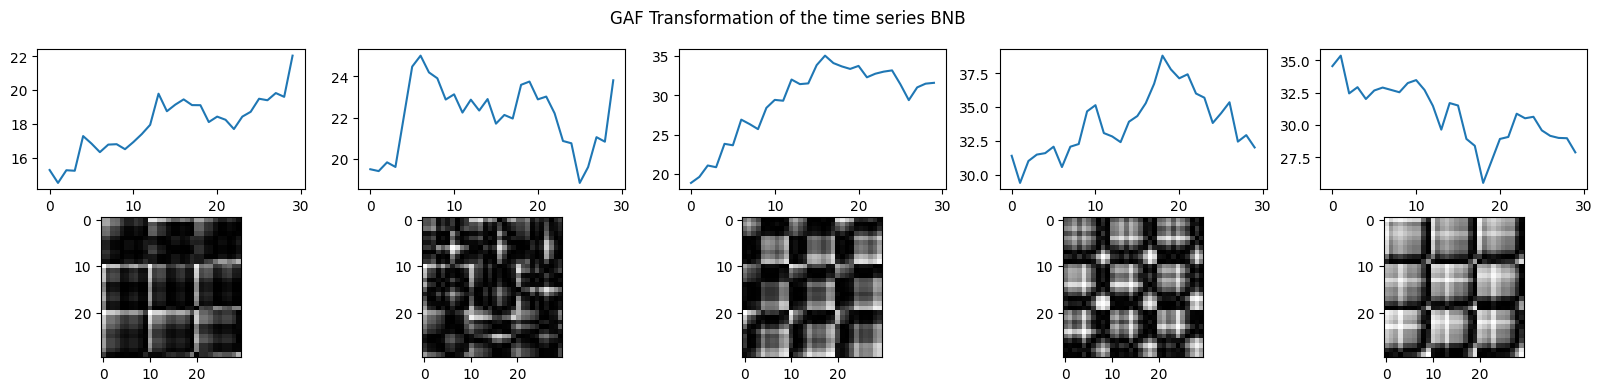

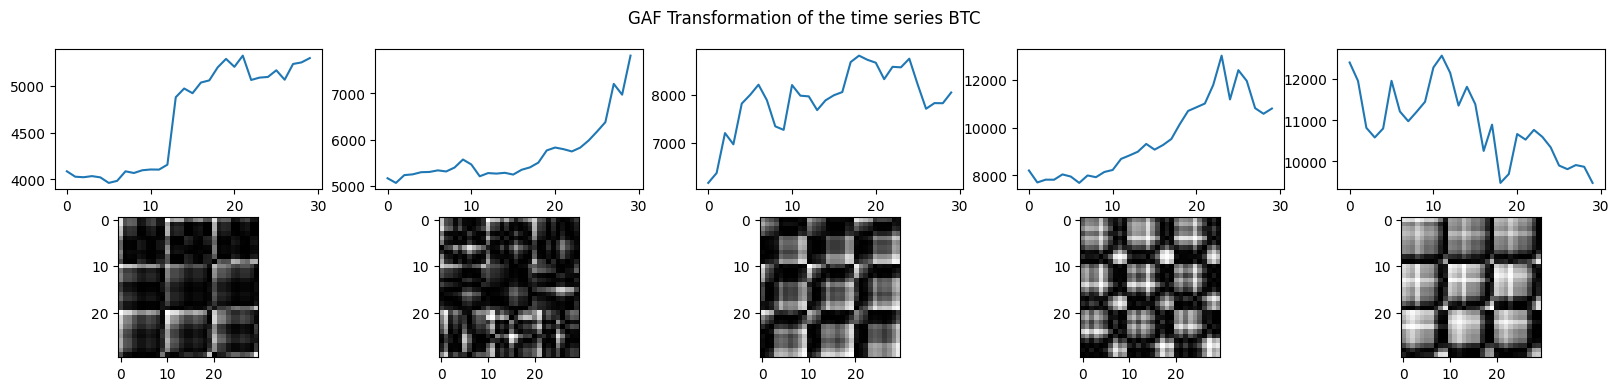

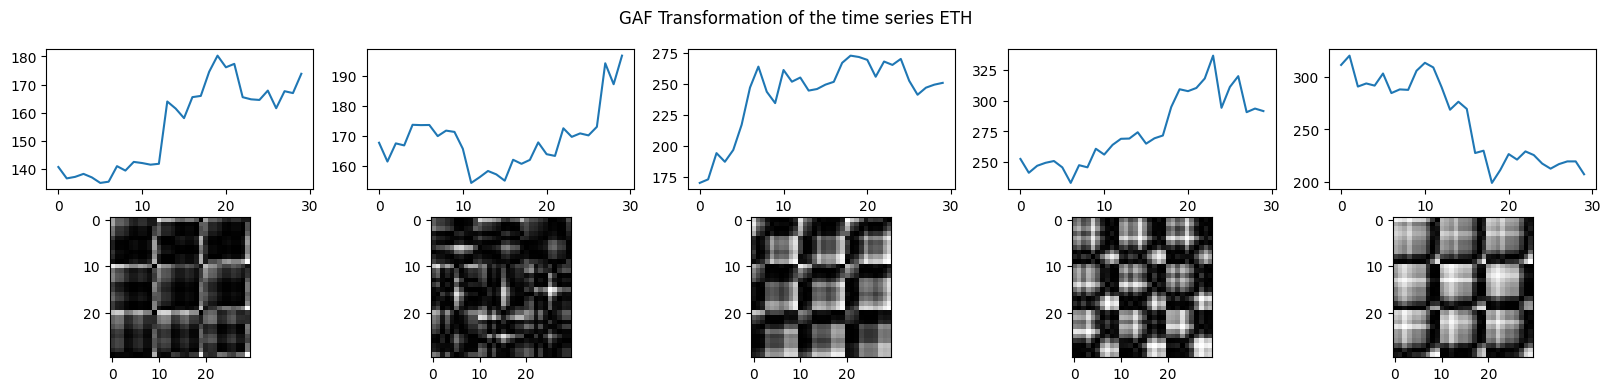

In [ ]:
for j in range(X.shape[3]):
    fig, ax = plt.subplots(2, 5, figsize=(20, 4))
    for i in range(0, 125, 25):
        ax[0, int(i / 25)].plot(X_data[i,:,j])
    for i in range(0, 125, 25):
        ax[1, int(i / 25)].imshow(X[i,:,:,j], "gray")
    plt.suptitle(f'GAF Transformation of the time series {tickers[j]}')
    plt.show()

In [ ]:
# train test split
train_split = 0.8
X_train = X[: int(train_split * X.shape[0])]
X_test = X[int(train_split * X.shape[0]):]

print(X_train.shape, X_test.shape)
y_train = y[: int(train_split * X.shape[0])]
y_test = y[int(train_split * X.shape[0]):]
print(y_train.shape, y_test.shape)

(1435, 30, 30, 3) (359, 30, 30, 3)
(1435,) (359,)


In [ ]:
train_test_time = Xdf.index[window_size:Xdf.shape[0] - dayret_ahead]
test_time = train_test_time[int(train_split * X.shape[0]):]
test_time.shape

(359,)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 64)          0

None

Epoch 1/100
18/18 [==============================] - 2s 66ms/step - loss: 12.7080 - accuracy: 0.4843 - val_loss: 0.9521 - val_accuracy: 0.4948
Epoch 2/100
18/18 [==============================] - 1s 46ms/step - loss: 1.0888 - accuracy: 0.5226 - val_loss: 0.9192 - val_accuracy: 0.4983
Epoch 3/100
18/18 [==============================] - 1s 52ms/step - loss: 1.2038 - accuracy: 0.5105 - val_loss: 0.7518 - val_accuracy: 0.4669
Epoch 4/100
18/18 [==============================] - 1s 47ms/step - loss: 1.0237 - accuracy: 0.5166 - val_loss: 0.7232 - val_accuracy: 0.4913
Epoch 5/100
18/18 [==============================] - 1s 48ms/step - loss: 1.0276 - accuracy: 0.5096 - val_loss: 0.7713 - val_accuracy: 0.5331
Epoch 6/100
18/18 [==============================] - 1s 49ms/step - loss: 1.2509 - accuracy: 0.4983 - val_loss: 0.7207 - val_accuracy: 0.4913
Epoch 7/100
18/18 [==============================] - 1s 81ms/step - loss: 1.1057 - accuracy: 0.5052 - val_loss: 0.7461 - val_accuracy: 0.4808
Epoch

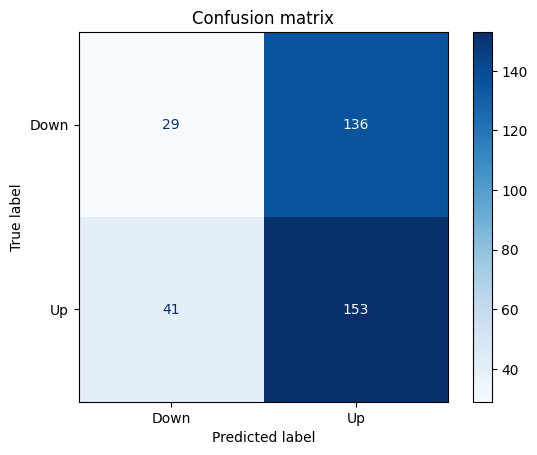

12/12 [==============================] - 0s 15ms/step
KerasClassifier train AUC score:  0.5912967855655903
KerasClassifier test AUC score:  0.4676663542642925


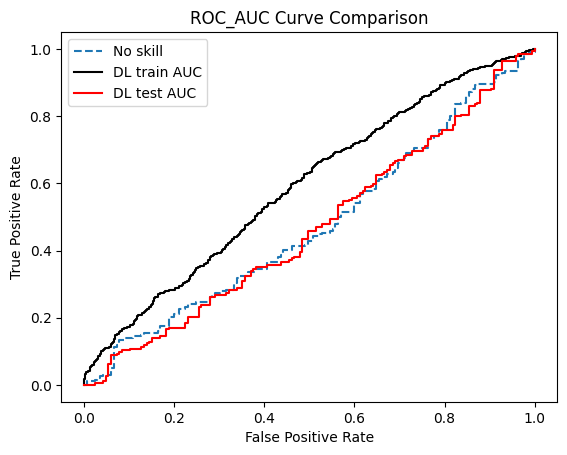

In [ ]:
#building CNN model
tf.keras.backend.clear_session()
tf.random.set_seed(1000)
model = tf.keras.Sequential()

# Input layer
model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 3)))
model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.3, seed=1234))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

display(model.summary())

model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

# checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
# )
#we adding callback to prevent overfit
es = tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy',mode="max",verbose=1,
                                      patience=20,restore_best_weights=True)
class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    validation_split=0.2,
    batch_size = 64,
    verbose=1,
    callbacks=[es],
    class_weight=class_weight,
)
# model = tf.keras.models.load_model("model.h5")
acc = model.evaluate(x=X_test, y=y_test)
print("Accuracy over validation: {:.2f}%".format(acc[1] * 100))

y_prob = model.predict(X_test).flatten()
y_pred = np.round(y_prob)
cm = metrics.confusion_matrix(y_test, y_pred)
cm = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])
cm.plot(values_format="", cmap="Blues")
print(classification_report(y_test, y_pred))
plt.title('Confusion matrix')
plt.show()

roc_auc_results(model, X_train, y_train,X_test,y_test)
plt.show()

This time we observe that our model is performing well and this maybe due to the fact that the CNN based on GAF model overfit notably on the train data set with 0.5913 AUC score, but only struck a suboptimal score of 0.47 on the test set.

Long - Short strategy Return = 35.952530054498546 %
Long only strategy Return = 59.88118726497225 %
Buy and Hold Return = 74.86673650935269 %


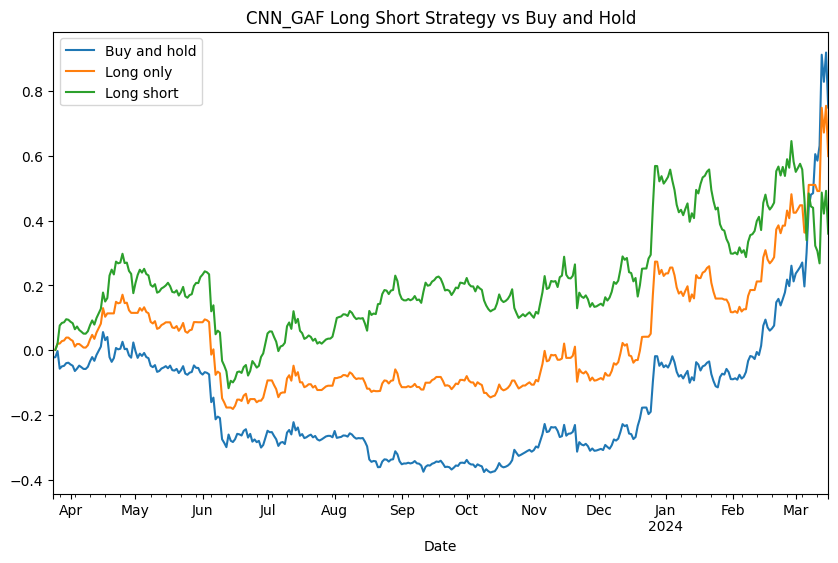

In [ ]:
# Backtesting trading strategy
df_predictions = pd.DataFrame(
    {"Date": test_time, "Pred CNN_GAF": y_pred, "True values": y_test})

df_predictions['ret'] = data['BNB_ret1'].loc[test_time].values

df_predictions["Positions"] = np.where(df_predictions["Pred CNN_GAF"] > 0, 1,-1)

df_predictions["Strat_ret"] = (df_predictions["Positions"].shift(1) * df_predictions["ret"])

df_predictions["Strat_ret_L"] = (df_predictions["Pred CNN_GAF"].shift(1) * df_predictions["ret"])

df_predictions["Strat_CumRet"] = (df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["Strat_CumRet_L"] = (df_predictions["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1))

df_predictions["BH_CumRet"] = (df_predictions["ret"].expanding().apply(lambda x: np.prod(1 + x) - 1))


Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
Long_only_return = np.prod(1 + df_predictions["Strat_ret_L"]) - 1
Buy_Return = np.prod(1 + df_predictions["ret"]) - 1

print("Long - Short strategy Return =", Final_Return * 100, "%")
print("Long only strategy Return =", Long_only_return * 100, "%")
print("Buy and Hold Return =", Buy_Return * 100, "%")
plt.figure(figsize = (10,6))
ax = plt.gca()
df_predictions.plot(x="Date", y="BH_CumRet", label = "Buy and hold", ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet_L", label = 'Long only', ax=ax)
df_predictions.plot(x="Date", y="Strat_CumRet", label = 'Long short', ax=ax)
plt.title(f'CNN_GAF Long Short Strategy vs Buy and Hold')
plt.show()

Comment: Beyond suspicion of

## Step 2. Train models using a (non-anchored) walk forward method that exploits a train/test split with 500 observations in each set.

### MLP model

In [ ]:
data = df.copy()

tickers = ['BNB','BTC','ETH']
data.columns = tickers
lags = [1,5,10,20]
return_days_ahead = 3
for lag in lags:
    for ticker in tickers:
        data[f'{ticker}_ret{lag}'] = data[ticker]/data[ticker].shift(lag) - 1
data['output'] = data['BNB'].shift(-return_days_ahead)/data['BNB'] - 1
data['output'] = (data['output'] > 0).astype('float32')
data = data.dropna()
data = data.iloc[:,3:]
X, y = data.iloc[:,:-1].astype('float32'), data.iloc[:,-1]

In [ ]:
X

,BNB_ret1,BTC_ret1,ETH_ret1,BNB_ret5,BTC_ret5,ETH_ret5,BNB_ret10,BTC_ret10,ETH_ret10,BNB_ret20,BTC_ret20,ETH_ret20
Date,,,,,,,,,,,,
2019-04-09,0.017741,-0.016033,-0.022991,-0.036966,0.057317,0.114279,0.088756,0.267443,0.239435,0.206481,0.273392,0.251824
2019-04-10,-0.010115,0.022977,0.006944,-0.061937,0.057155,0.071429,0.048668,0.296962,0.253144,0.257015,0.321449,0.297882
2019-04-11,-0.030035,-0.048842,-0.066768,-0.074031,0.000923,-0.002713,-0.013928,0.217957,0.166866,0.159438,0.258580,0.206410
2019-04-12,0.041456,0.004946,-0.004596,-0.035374,-0.021035,-0.056123,-0.068496,0.042964,0.004724,0.209916,0.261090,0.191670
2019-04-13,0.015489,0.001385,-0.001354,0.033461,-0.036520,-0.087349,-0.001774,0.024847,0.018918,0.082986,0.267124,0.200942
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15,0.049444,-0.027912,-0.038093,0.195378,0.005563,-0.037610,0.603405,0.087813,0.050705,0.657668,0.345788,0.248241
2024-03-16,-0.088539,-0.058911,-0.056853,0.103416,-0.094404,-0.133676,0.344427,-0.011976,-0.077598,0.484423,0.262537,0.131771
2024-03-17,-0.009865,0.047087,0.033936,0.061762,-0.043237,-0.084884,0.201550,0.021892,-0.059864,0.421870,0.254358,0.145776


In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

hp_units = 64;
hp_units_2 = 32;
hp_units_3 = 16;
hp_units_4 = 8;

n_dropout = 0.2
act_fun = "relu"

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = X.index[i + (n_train) : i + n_train + n_test]
    Ret_vector = X['BNB_ret1'].iloc[i + (n_train) : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: 2020-08-21 00:00:00  -- end test 2020-11-28 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  1.0  -- start test: 2020-11-29 00:00:00  -- end test 2021-03-08 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  2.0  -- start test: 2021-03-09 00:00:00  -- end test 2021-06-16 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  3.0  -- start test: 2021-06-17 00:00:00  -- end test 2021-09-24 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  4.0  -- start test: 2021-09-25 00:00:00  -- end test 2022-01-02 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  5.0  -- start test: 2022-01-03 00:00:00  -- end test 2022-04-12 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  6.0  -- start test: 2022-04-13 00:00:00  -- end test 2022-07-21 00:00:00  -------  (500, 12) (500,) (100, 12) (100,) (100,) (100,)
ite  7.0  -- start test: 2022-07-22 00:00:00  --

<ipython-input-455-d0ada0c6e945>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 1009.4125734822011 %
Strat Sharpe Ratio Long Only = 0.06
Strat Return Long/Short = 66.65053051189491 %
Strat Sharpe Ratio Long/Short = 0.03
Buy and Hold Return = 2095.8425209766915 %
Buy and Hold Return Sharpe Ratio  = 0.07


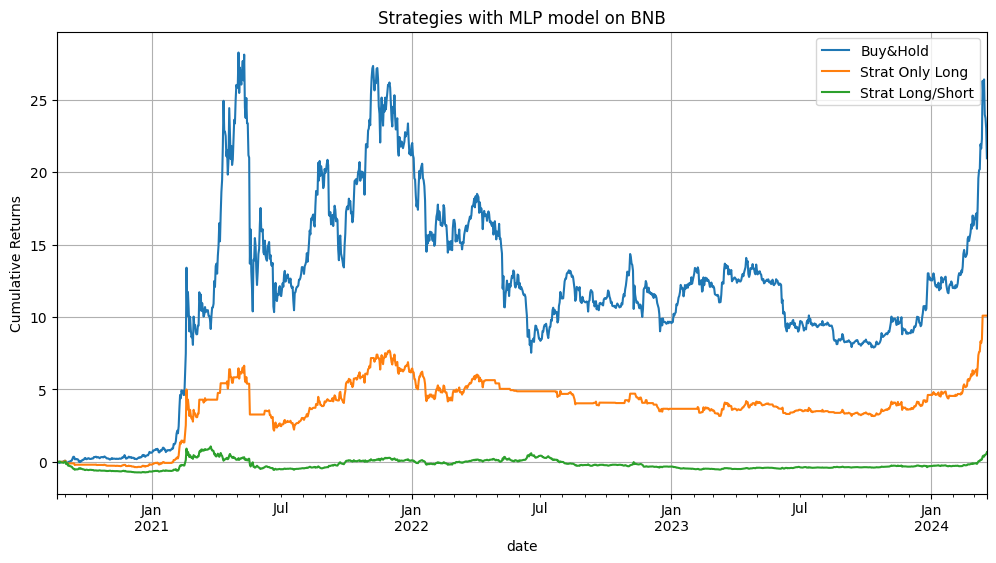

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", Final_Return_L * 100, "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", Final_Return * 100, "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", Buy_Return * 100, "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with MLP model on BNB')
plt.show()

# df_res["trade_bin"] = df_res["Positions"].diff().abs()
# df_res["trade_bin"] = df_res["trade_bin"] / 2
# df_res.describe()

As we can observer from the resulting graph, Our long/short strategy was the worst perfoming when applying walk forward MLP to predict 3 day ahead returns of BNB using a rolling window of 500 days BTC, ETH, BNB as predictors.. The long only Strategy was doing a decent job with sharpe ratio of 0.06 which is slightly less than the sharpe ratio 0.07 of the buy and hold strategy

### LSTM Model


In [ ]:
data = df.copy()

tickers = ['BNB','BTC','ETH']
data.columns = tickers
lags = [1,5,10,20]
return_days_ahead = 3
for lag in lags:
    for ticker in tickers:
        data[f'{ticker}_ret{lag}'] = data[ticker]/data[ticker].shift(lag) - 1
data['output'] = data['BNB'].shift(-return_days_ahead)/data['BNB'] - 1
data['output'] = (data['output'] > 0).astype('float32')
data = data.dropna()
data = data.iloc[:,3:]
X, y = data.iloc[:,:-1].astype('float32'), data.iloc[:,-1]
window_size = 30

X_lstm = []
y_lstm = []

for i in range(window_size, X.shape[0]):
    X_lstm.append(X.iloc[i - window_size : i, :])
    y_lstm.append(y.iloc[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

time_vec = X.index[window_size:]
ret_vec = X['BNB_ret1'].iloc[window_size:]

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

lstm_layers = 4
dense_structure = [16,8,1]
units_lstm = 30
n_dropout = 0.3
dense_act_fun = "relu"
final_act_fun = 'sigmoid'
hp_lr = 1e-4
loss = "binary_crossentropy"
epochs = 50
verbose = 1
batch_size = 32
SEED = 1234

for i in range(0, len(y_lstm) - n_train, n_test):
    X_train, X_test = X_lstm[i : i + (n_train)], X_lstm[i + n_train : i + n_train + n_test]
    y_train, y_test = y_lstm[i : i + (n_train)], y_lstm[i + n_train : i + n_train + n_test]
    test_time = time_vec[i + (n_train) : i + n_train + n_test]
    Ret_vector = ret_vec.iloc[i + (n_train) : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    model = Sequential()

    model.add(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=(X_train.shape[1], X_train.shape[2]),
        )
    )
    for layers in range(1,lstm_layers):
        if layers + 1 != lstm_layers:
            model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))

    for i, dense in list(enumerate(dense_structure)):
        if i + 1 < len(dense_structure):
            model.add(Dense(units=dense, activation=dense_act_fun))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(Dense(1,activation = final_act_fun))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
    )

    #return summary
    #summary =  model.summary()

    # fit the models
    model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs= epochs,
        batch_size = batch_size,
        verbose = verbose,
        callbacks=[es],
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: 2020-09-20 00:00:00  -- end test 2020-12-28 00:00:00  -------  (500, 30, 12) (500,) (100, 30, 12) (100,) (100,) (100,)
Epoch 1/50
13/13 [==============================] - 11s 267ms/step - loss: 0.6935 - val_loss: 0.6928
Epoch 2/50
13/13 [==============================] - 1s 61ms/step - loss: 0.6933 - val_loss: 0.6925
Epoch 3/50
13/13 [==============================] - 1s 61ms/step - loss: 0.6938 - val_loss: 0.6925
Epoch 4/50
13/13 [==============================] - 1s 61ms/step - loss: 0.6930 - val_loss: 0.6923
Epoch 5/50
13/13 [==============================] - 1s 61ms/step - loss: 0.6930 - val_loss: 0.6925
Epoch 6/50
13/13 [==============================] - 1s 62ms/step - loss: 0.6928 - val_loss: 0.6925
Epoch 7/50
13/13 [==============================] - 1s 62ms/step - loss: 0.6935 - val_loss: 0.6925
Epoch 8/50
13/13 [==============================] - 1s 62ms/step - loss: 0.6937 - val_loss: 0.6924
Epoch 9/50
13/13 [==============================] - 1s 61ms/st

<ipython-input-19-ebfe0b96ecca>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 2002.26 %
Strat Sharpe Ratio Long Only = 0.07
Strat Return Long/Short = 1810.9 %
Strat Sharpe Ratio Long/Short = 0.07
Buy and Hold Return = 1760.76 %
Buy and Hold Return Sharpe Ratio  = 0.07


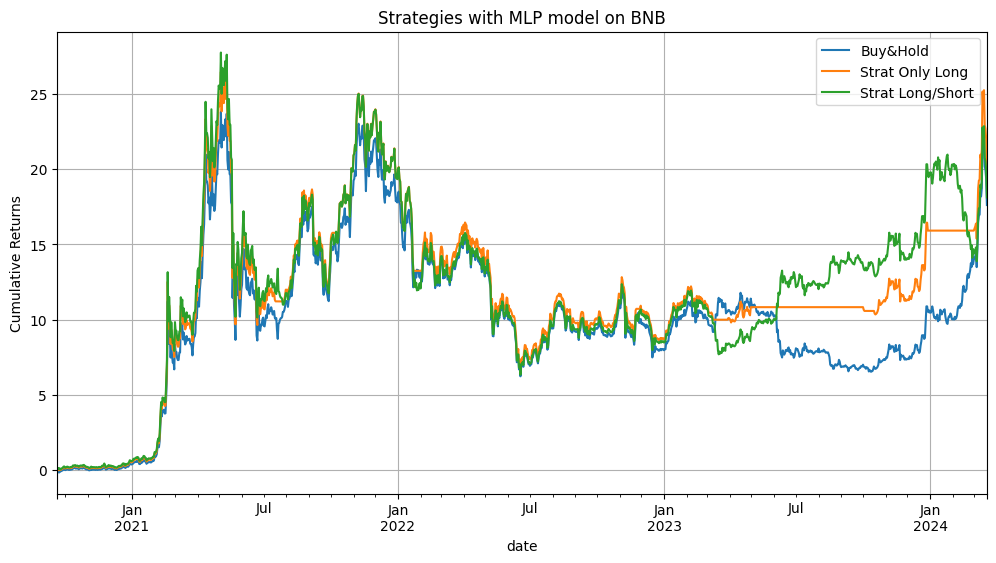

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", round(Final_Return_L * 100,2), "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", round(Final_Return * 100,2), "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", round(Buy_Return * 100,2), "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with LSTM model on BNB')
plt.show()

### CNN based on GAF model

Comment:

In [ ]:
Xdf = df.copy()
Xdf.dropna(inplace = True)
X_data = []
window_size = 30
for i in range(window_size, Xdf.shape[0]):
    X_data.append(Xdf.iloc[i - window_size : i])
X_data = np.array(X_data)

#GAF transform
transformer = GramianAngularField()
X = []
for asset in range(X_data.shape[2]):
    X.append(transformer.transform(X_data[:,:,asset]))
X = np.array(X)
X = X.reshape((1797, 30, 30,3))

dayret_ahead = 3 # day return ahead
y = []
for i in range(window_size, Xdf.shape[0] - dayret_ahead):
    y.append(Xdf['BNB-USD'].iloc[i] < Xdf['BNB-USD'].iloc[i + dayret_ahead])
y = np.array(y).astype("float32")

X = X[:y.shape[0]]
X.shape

print('X shape', X.shape,'\n y shape', y.shape)

# minmax scaler for each channel of each observation
for i in range(X.shape[0]):
    for j in range(X.shape[3]):
        X[i,:,:,j] = (X[i,:,:,j] - np.min(X[i,:,:,j])) / (
        np.max(X[i,:,:,j]) - np.min(X[i,:,:,j]))
X = X * 255.0

time_vec = Xdf.index[window_size:]
time_vec = time_vec[:y.shape[0]]
ret_vec = Xdf['BNB-USD'].pct_change().iloc[window_size:]
ret_vec = ret_vec[:y.shape[0]]

X shape (1794, 30, 30, 3) 
 y shape (1794,)


In [ ]:
time_vec.shape, ret_vec.shape

((1794,), (1794,))

In [ ]:
len(y) -n_train

-3206

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train : i + n_train + n_test]
    test_time = time_vec[i + (n_train) : i + n_train + n_test]
    Ret_vector = ret_vec.iloc[i + (n_train) : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    #building CNN model
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 3)))
    model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.3, seed=1234))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # display(model.summary())

    model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

    # checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #     "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
    # )
    #we adding callback to prevent overfit
    es = tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy',mode="max",verbose=0,
                                          patience=20,restore_best_weights=True)
    class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

    model.fit(
        x=X_train,
        y=y_train,
        epochs=100,
        validation_split=0.2,
        batch_size = 64,
        verbose=1,
        callbacks=[es],
        class_weight=class_weight,
    )
    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)


ite  0.0  -- start test: 2020-08-31 00:00:00  -- end test 2020-12-08 00:00:00  -------  (500, 30, 30, 3) (500,) (100, 30, 30, 3) (100,) (100,) (100,)
Epoch 1/100
7/7 [==============================] - 2s 86ms/step - loss: 43.6745 - accuracy: 0.5125 - val_loss: 11.1996 - val_accuracy: 0.4200
Epoch 2/100
7/7 [==============================] - 0s 52ms/step - loss: 4.4645 - accuracy: 0.4900 - val_loss: 1.0047 - val_accuracy: 0.4900
Epoch 3/100
7/7 [==============================] - 0s 48ms/step - loss: 1.2789 - accuracy: 0.5400 - val_loss: 1.5640 - val_accuracy: 0.4200
Epoch 4/100
7/7 [==============================] - 0s 47ms/step - loss: 1.1118 - accuracy: 0.5725 - val_loss: 1.0946 - val_accuracy: 0.3900
Epoch 5/100
7/7 [==============================] - 0s 59ms/step - loss: 1.0187 - accuracy: 0.5800 - val_loss: 1.0987 - val_accuracy: 0.4500
Epoch 6/100
7/7 [==============================] - 1s 79ms/step - loss: 0.9612 - accuracy: 0.6075 - val_loss: 1.0993 - val_accuracy: 0.4700
Epoch 7/

<ipython-input-57-1ab15ad65004>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 195.15 %
Strat Sharpe Ratio Long Only = 0.04
Strat Return Long/Short = -94.24 %
Strat Sharpe Ratio Long/Short = -0.01
Buy and Hold Return = 2339.32 %
Buy and Hold Return Sharpe Ratio  = 0.07


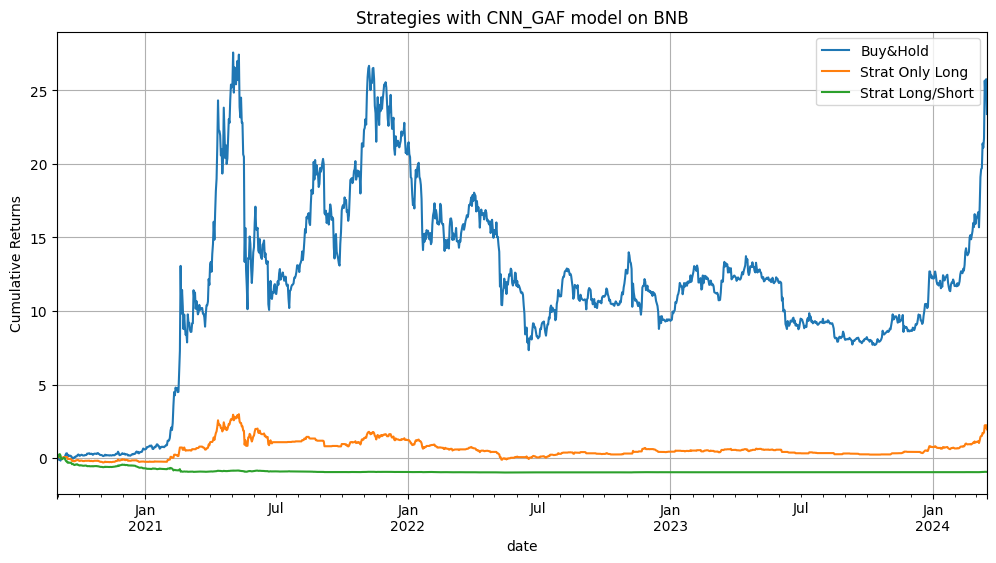

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", round(Final_Return_L * 100,2), "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", round(Final_Return * 100,2), "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", round(Buy_Return * 100,2), "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with CNN_GAF model on BNB')
plt.show()

Comment:

## Step 3. repeat the same process as in Step 2 but alleviating the leakage of information between training and test sets.

In [ ]:
dayret_ahead

3

### MLP Model

In [ ]:
data = df.copy()

tickers = ['BNB','BTC','ETH']
data.columns = tickers
lags = [1,5,10,20]
return_days_ahead = 3
for lag in lags:
    for ticker in tickers:
        data[f'{ticker}_ret{lag}'] = data[ticker]/data[ticker].shift(lag) - 1
data['output'] = data['BNB'].shift(-return_days_ahead)/data['BNB'] - 1
data['output'] = (data['output'] > 0).astype('float32')
data = data.dropna()
data = data.iloc[:,3:]
X, y = data.iloc[:,:-1].astype('float32'), data.iloc[:,-1]

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

hp_units = 64;
hp_units_2 = 32;
hp_units_3 = 16;
hp_units_4 = 8;

n_dropout = 0.2
act_fun = "relu"

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train + dayret_ahead : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train + dayret_ahead : i + n_train + n_test]
    test_time = X.index[i + (n_train) + dayret_ahead : i + n_train + n_test]
    Ret_vector = X['BNB_ret1'].iloc[i + (n_train) + dayret_ahead : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(units=hp_units, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_2, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_3, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=hp_units_4, activation=act_fun))
    model.add(tf.keras.layers.Dropout(n_dropout))
    model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    hp_lr = 1e-5

    adam = tf.keras.optimizers.Adam(learning_rate=hp_lr)
    model.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

    es = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        mode="max",
        verbose=0,
        patience=20,
        restore_best_weights=True,
    )
    class_weight = {0: (np.mean(y_train) / 0.5), 1: 1}
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.15,
        epochs=500,
        batch_size=32,
        verbose=0,
        callbacks=[es],
        class_weight=class_weight,
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)

ite  0.0  -- start test: 2020-08-24 00:00:00  -- end test 2020-11-28 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)


ite  1.0  -- start test: 2020-12-02 00:00:00  -- end test 2021-03-08 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)


ite  2.0  -- start test: 2021-03-12 00:00:00  -- end test 2021-06-16 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  3.0  -- start test: 2021-06-20 00:00:00  -- end test 2021-09-24 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  4.0  -- start test: 2021-09-28 00:00:00  -- end test 2022-01-02 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  5.0  -- start test: 2022-01-06 00:00:00  -- end test 2022-04-12 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  6.0  -- start test: 2022-04-16 00:00:00  -- end test 2022-07-21 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  7.0  -- start test: 2022-07-25 00:00:00  -- end test 2022-10-29 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  8.0  -- start test: 2022-11-02 00:00:00  -- end test 2023-02-06 00:00:00  -------  (500, 12) (500,) (97, 12) (97,) (97,) (97,)
ite  9.0  -- start test: 2023-02-10 00:00:00  -- end test 2023-05-17 00:00:0

<ipython-input-67-aad152fac643>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 212.7 %
Strat Sharpe Ratio Long Only = 0.05
Strat Return Long/Short = -96.55 %
Strat Sharpe Ratio Long/Short = -0.02
Buy and Hold Return = 1839.13 %
Buy and Hold Return Sharpe Ratio  = 0.07


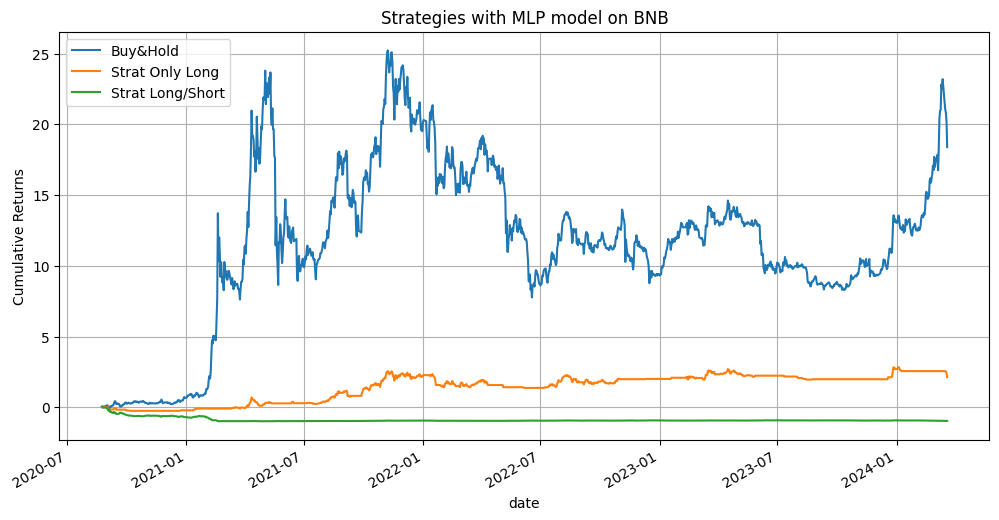

In [ ]:
df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", round(Final_Return_L * 100,2), "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", round(Final_Return * 100,2), "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", round(Buy_Return * 100,2), "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with MLP model on BNB')
plt.show()

# df_res["trade_bin"] = df_res["Positions"].diff().abs()
# df_res["trade_bin"] = df_res["trade_bin"] / 2
# df_res.describe()

Comment:

### LSTM Model


In [ ]:
data = df.copy()

tickers = ['BNB','BTC','ETH']
data.columns = tickers
lags = [1,5,10,20]
return_days_ahead = 3
for lag in lags:
    for ticker in tickers:
        data[f'{ticker}_ret{lag}'] = data[ticker]/data[ticker].shift(lag) - 1
data['output'] = data['BNB'].shift(-return_days_ahead)/data['BNB'] - 1
data['output'] = (data['output'] > 0).astype('float32')
data = data.dropna()
data = data.iloc[:,3:]
X, y = data.iloc[:,:-1].astype('float32'), data.iloc[:,-1]
window_size = 30

X_lstm = []
y_lstm = []

for i in range(window_size, X.shape[0]):
    X_lstm.append(X.iloc[i - window_size : i, :])
    y_lstm.append(y.iloc[i])
X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

time_vec = X.index[window_size:]
ret_vec = X['BNB_ret1'].iloc[window_size:]

ite  0.0  -- start test: 2020-09-23 00:00:00  -- end test 2020-12-28 00:00:00  -------  (500, 30, 12) (500,) (97, 30, 12) (97,) (97,) (97,)
Epoch 1/50
13/13 [==============================] - 14s 236ms/step - loss: 0.6938 - val_loss: 0.6938
Epoch 2/50
13/13 [==============================] - 1s 69ms/step - loss: 0.6940 - val_loss: 0.6938
Epoch 3/50
13/13 [==============================] - 1s 100ms/step - loss: 0.6931 - val_loss: 0.6938
Epoch 4/50
13/13 [==============================] - 1s 106ms/step - loss: 0.6930 - val_loss: 0.6937
Epoch 5/50
13/13 [==============================] - 1s 78ms/step - loss: 0.6937 - val_loss: 0.6937
Epoch 6/50
13/13 [==============================] - 1s 68ms/step - loss: 0.6936 - val_loss: 0.6937
Epoch 7/50
13/13 [==============================] - 1s 68ms/step - loss: 0.6940 - val_loss: 0.6937
Epoch 8/50
13/13 [==============================] - 1s 68ms/step - loss: 0.6935 - val_loss: 0.6937
Epoch 9/50
13/13 [==============================] - 1s 75ms/step

<ipython-input-71-88fbce199f4f>:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 644.55 %
Strat Sharpe Ratio Long Only = 0.06
Strat Return Long/Short = 90.77 %
Strat Sharpe Ratio Long/Short = 0.03
Buy and Hold Return = 1334.35 %
Buy and Hold Return Sharpe Ratio  = 0.07


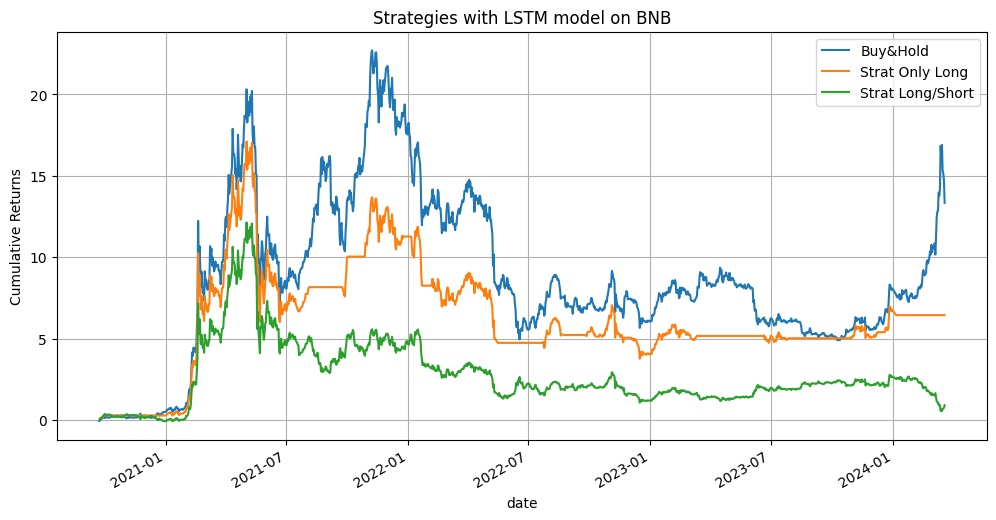

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

lstm_layers = 4
dense_structure = [16,8,1]
units_lstm = 30
n_dropout = 0.3
dense_act_fun = "relu"
final_act_fun = 'sigmoid'
hp_lr = 1e-4
loss = "binary_crossentropy"
epochs = 50
verbose = 1
batch_size = 32
SEED = 1234

for i in range(0, len(y_lstm) - n_train, n_test):
    X_train, X_test = X_lstm[i : i + (n_train)], X_lstm[i + n_train + dayret_ahead : i + n_train + n_test]
    y_train, y_test = y_lstm[i : i + (n_train)], y_lstm[i + n_train + dayret_ahead : i + n_train + n_test]
    test_time = time_vec[i + (n_train) + dayret_ahead : i + n_train + n_test]
    Ret_vector = ret_vec.iloc[i + (n_train) + dayret_ahead : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    tf.keras.backend.clear_session()
    tf.random.set_seed(SEED)
    model = Sequential()

    model.add(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=(X_train.shape[1], X_train.shape[2]),
        )
    )
    for layers in range(1,lstm_layers):
        if layers + 1 != lstm_layers:
            model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
            model.add(Dropout(n_dropout, seed=SEED))

    for i, dense in list(enumerate(dense_structure)):
        if i + 1 < len(dense_structure):
            model.add(Dense(units=dense, activation=dense_act_fun))
            model.add(Dropout(n_dropout, seed=SEED))
        else:
            model.add(Dense(1,activation = final_act_fun))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss= loss)

    es = EarlyStopping(
        monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
    )

    #return summary
    #summary =  model.summary()

    # fit the models
    model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs= epochs,
        batch_size = batch_size,
        verbose = verbose,
        callbacks=[es],
    )

    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)


df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", round(Final_Return_L * 100,2), "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", round(Final_Return * 100,2), "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", round(Buy_Return * 100,2), "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with LSTM model on BNB')
plt.show()

### CNN based on GAF model

In [ ]:
Xdf = df.copy()
Xdf.dropna(inplace = True)
X_data = []
window_size = 30
for i in range(window_size, Xdf.shape[0]):
    X_data.append(Xdf.iloc[i - window_size : i])
X_data = np.array(X_data)

#GAF transform
transformer = GramianAngularField()
X = []
for asset in range(X_data.shape[2]):
    X.append(transformer.transform(X_data[:,:,asset]))
X = np.array(X)
X = X.reshape((1797, 30, 30,3))

dayret_ahead = 3 # day return ahead
y = []
for i in range(window_size, Xdf.shape[0] - dayret_ahead):
    y.append(Xdf['BNB-USD'].iloc[i] < Xdf['BNB-USD'].iloc[i + dayret_ahead])
y = np.array(y).astype("float32")

X = X[:y.shape[0]]
X.shape

print('X shape', X.shape,'\n y shape', y.shape)

# minmax scaler for each channel of each observation
for i in range(X.shape[0]):
    for j in range(X.shape[3]):
        X[i,:,:,j] = (X[i,:,:,j] - np.min(X[i,:,:,j])) / (
        np.max(X[i,:,:,j]) - np.min(X[i,:,:,j]))
X = X * 255.0

time_vec = Xdf.index[window_size:]
time_vec = time_vec[:y.shape[0]]
ret_vec = Xdf['BNB-USD'].pct_change().iloc[window_size:]
ret_vec = ret_vec[:y.shape[0]]

X shape (1794, 30, 30, 3) 
 y shape (1794,)


ite  0.0  -- start test: 2020-09-03 00:00:00  -- end test 2020-12-08 00:00:00  -------  (500, 30, 30, 3) (500,) (97, 30, 30, 3) (97,) (97,) (97,)
Epoch 1/100
7/7 [==============================] - 3s 208ms/step - loss: 32.3807 - accuracy: 0.5025 - val_loss: 6.9938 - val_accuracy: 0.4200
Epoch 2/100
7/7 [==============================] - 0s 58ms/step - loss: 2.4452 - accuracy: 0.5000 - val_loss: 1.0550 - val_accuracy: 0.4500
Epoch 3/100
7/7 [==============================] - 0s 54ms/step - loss: 1.2676 - accuracy: 0.5375 - val_loss: 3.2403 - val_accuracy: 0.4200
Epoch 4/100
7/7 [==============================] - 0s 54ms/step - loss: 1.1827 - accuracy: 0.5800 - val_loss: 0.8394 - val_accuracy: 0.4800
Epoch 5/100
7/7 [==============================] - 0s 55ms/step - loss: 0.9379 - accuracy: 0.6250 - val_loss: 0.8506 - val_accuracy: 0.4400
Epoch 6/100
7/7 [==============================] - 1s 86ms/step - loss: 0.9410 - accuracy: 0.5975 - val_loss: 0.8889 - val_accuracy: 0.4700
Epoch 7/100


<ipython-input-76-3e9462b7ba91>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Positions_L"][df_res["Positions_L"] == -1] = 0


Strat Return Long Only = 522.92 %
Strat Sharpe Ratio Long Only = 0.06
Strat Return Long/Short = -76.71 %
Strat Sharpe Ratio Long/Short = 0.01
Buy and Hold Return = 2114.5 %
Buy and Hold Return Sharpe Ratio  = 0.07


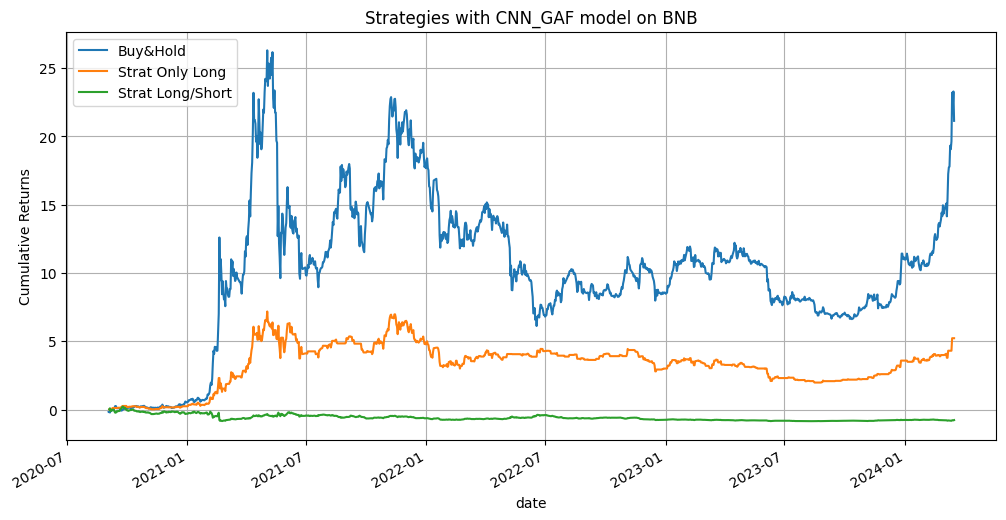

In [ ]:
n_train = 500
n_test = 100

time_backtest = []
time_backtest = np.array(time_backtest)
time_backtest = time_backtest.astype("datetime64", copy=False)

pred_backtest = []
ret_backtest = []

for i in range(0, len(y) - n_train, n_test):
    X_train, X_test = X[i : i + (n_train)], X[i + n_train  + dayret_ahead : i + n_train + n_test]
    y_train, y_test = y[i : i + (n_train)], y[i + n_train + dayret_ahead : i + n_train + n_test]
    test_time = time_vec[i + (n_train) + dayret_ahead : i + n_train + n_test]
    Ret_vector = ret_vec.iloc[i + (n_train) + dayret_ahead : i + n_train + n_test]
    print(
        "ite ",
        i / n_test,
        " -- start test:",
        test_time[0],
        " -- end test",
        test_time[-1],
        " ------- ",
        X_train.shape,
        y_train.shape,
        X_test.shape,
        y_test.shape,
        test_time.shape,
        Ret_vector.shape,
    )

    #building CNN model
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = tf.keras.Sequential()

    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(30, 30, 3)))
    model.add(tf.keras.layers.Conv2D(16, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(32, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Conv2D(64, 3, activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1024, activation="relu"))
    model.add(tf.keras.layers.Dropout(0.3, seed=1234))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # display(model.summary())

    model.compile(loss="binary_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

    # checkpoint = tf.keras.callbacks.ModelCheckpoint(
    #     "model.h5", monitor="val_accuracy", save_best_only=True, mode="auto"
    # )
    #we adding callback to prevent overfit
    es = tf.keras.callbacks.EarlyStopping(monitor= 'val_accuracy',mode="max",verbose=0,
                                          patience=20,restore_best_weights=True)
    class_weight = {0: 1 / (1 - np.mean(y_train)), 1: 1.0}

    model.fit(
        x=X_train,
        y=y_train,
        epochs=100,
        validation_split=0.2,
        batch_size = 64,
        verbose=1,
        callbacks=[es],
        class_weight=class_weight,
    )
    y_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = np.where(y_prob > 0.50, 1, 0)

    time_backtest = np.append(time_backtest, test_time)
    pred_backtest = np.append(pred_backtest, y_pred)
    ret_backtest = np.append(ret_backtest, Ret_vector)

df_predictions = pd.DataFrame(
    {"Date": time_backtest, "Pred": pred_backtest, "Ret": ret_backtest}
)


df_predictions.Date = pd.to_datetime(df_predictions.Date, format="%YYYY-%mm-%dd")
df_res = df_predictions
df_res["Positions"] = np.where(df_res["Pred"] > 0.5, 1, -1)
df_res["Positions_shift"] = df_res["Positions"].shift(1)
df_res["Strat_ret"] = df_res["Positions"].shift(1) * df_res["Ret"]
df_res["Positions_L"] = df_res["Positions"].shift(1)
df_res["Positions_L"][df_res["Positions_L"] == -1] = 0
df_res["Strat_ret_L"] = df_res["Positions_L"] * df_res["Ret"]
df_res["CumRet"] = df_res["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
df_res["CumRet_L"] = (
    df_res["Strat_ret_L"].expanding().apply(lambda x: np.prod(1 + x) - 1)
)
df_res["bhRet"] = df_res["Ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)

Final_Return_L = np.prod(1 + df_res["Strat_ret_L"]) - 1
Final_Return = np.prod(1 + df_res["Strat_ret"]) - 1
Buy_Return = np.prod(1 + df_res["Ret"]) - 1

print("Strat Return Long Only =", round(Final_Return_L * 100,2), "%")
print("Strat Sharpe Ratio Long Only =", round(df_res["Strat_ret_L"].mean()/df_res["Strat_ret_L"].std(),2))
print("Strat Return Long/Short =", round(Final_Return * 100,2), "%")
print("Strat Sharpe Ratio Long/Short =", round(df_res["Strat_ret"].mean()/df_res["Strat_ret"].std(),2))
print("Buy and Hold Return =", round(Buy_Return * 100,2), "%")
print("Buy and Hold Return Sharpe Ratio  =", round(df_res["Ret"].mean()/df_res["Ret"].std(),2))

fig = plt.figure(figsize=(12, 6))
ax = plt.gca()
df_res.plot(x="Date", y="bhRet", label="Buy&Hold", ax=ax)
df_res.plot(x="Date", y="CumRet_L", label="Strat Only Long", ax=ax)
df_res.plot(x="Date", y="CumRet", label="Strat Long/Short", ax=ax)
plt.xlabel("date")
plt.ylabel("Cumulative Returns")
plt.grid()
plt.title('Strategies with CNN_GAF model on BNB')
plt.show()

# Conclusion

In the end, we have analysed the statistical properties of the time series. Analysing the ETFs data revealed some compelling trends and patterns which conveyed the importance of carefully reasoning out the most appropriate way to preprocess the time series data. In our case, we saw that the time series data was all stationary.

In this study, we developed deep learning models and demonstrated the power of Multilayer Perceptrons (MLP), Long Short-Term Memory (LSTM) networks, and Convolutional Neural Networks (CNN) based on Gramian Angular Field (GAF) to forecast the behaviour of Binance Coin (BNB). We trained and tested each model on the in-sample predictive performance as well as the out-of-sample predictive performance. By including both single train/test split and walk-forward methods, we have endeavoured to enhance the robustness and generalizability of our models.

We look forward to perhaps exploring alternative deep learning architectures such as ensemble methods and hybrid models which improve the predictive outcomes and generalizability even further. We did not incorporate hyperparameter optimization this time around and therefore this is yet another prospective way to improve the predictive performance. Furthermore, Bayesian Optimization and examining the differences produced through probabilities could also be designated for future research endeavours.

Nevertheless, utilizing these techniques clearly boasts a promising hope and future for model efficacy and more accurate predictive capabilities as such deep learning models secure their place in every finance house as a staple resource for market exploration and exploitation. These computational methods will definitely unlock new opportunities for financial engineers and market practitioners, helping them to navigate the intricately interwoven and ever complex modern finance world with better confidence and precision.


---
This notebook is the work and compilation of Joseph Olusegun Osuntoki, Ma Quang Son and Heathcliff Tatenda Nyambiya